# Assignment 2: Anime Recommendation Analysis

## Dataset: Anime Recommendations Database

This notebook contains the analysis for anime rating prediction and classification using machine learning.


---

# Section 1: Identify the Predictive Task

## Task 1: Regression - Predicting Anime Rating

Predict the rating of an anime (continuous value from 1-10).

- Input: Anime features (genre, type, episodes, members)
- Output: Rating (continuous value, typically 1-10)
- Problem Type: Supervised regression
- Dataset: User ratings from `rating.csv` aggregated per anime, merged with `anime.csv` features

## Task 2: Multiclass Classification - Predicting Anime Type (All 6 Types)

Predict the type of an anime among all 6 categories: TV, OVA, Movie, Special, ONA, Music.

- Input: Anime features (genre, episodes, members) from `anime.csv` (type is the target, not a feature)
- Output: Multiclass label (TV, OVA, Movie, Special, ONA, Music) from `anime.csv`
- Problem Type: Supervised multiclass classification
- Dataset: Samples with valid type labels from `anime.csv` (all 6 types)


## How We Will Evaluate Our Models

### Task 1 (Regression - Rating Prediction):

- **RMSE (Root Mean Squared Error):** Primary metric for regression
- **R² Score:** Proportion of variance explained (0 = baseline, 1 = perfect)
- **MAE (Mean Absolute Error):** Average prediction error

**Evaluation Protocol:**
- 80/20 train/test split
- 5-fold cross-validation for model selection
- Report RMSE, R², and MAE on test set

### Task 2 (Multiclass Classification - Type Prediction):

- **Accuracy:** Overall correctness across all classes
- **Macro-averaged Precision:** Average precision across all classes
- **Macro-averaged Recall:** Average recall across all classes
- **Macro-averaged F1-Score:** Average F1 across all classes
- **Weighted F1-Score:** F1 weighted by class frequency
- **Per-class Precision/Recall/F1:** Individual class performance

**Evaluation Protocol:**
- 80/20 stratified train/test split
- 5-fold stratified cross-validation for model selection
- Report accuracy, macro/weighted averages, and per-class metrics
- Confusion matrix for visualization


## Relevant Baselines for Comparison

### Task 1 (Regression - Rating Prediction):

**Baseline 1: Mean Rating Predictor**
- Always predicts the mean rating
- Expected: R² = 0, baseline RMSE

**Baseline 2: Linear Regression (No Regularization)** - **MAIN BASELINE**
- Linear Regression without regularization
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance before adding regularization

**Comparison:** Our optimized models (Random Forest Regressor and XGBoost Regressor) should outperform this baseline, demonstrating the benefits of non-linear models and ensemble methods for capturing complex feature relationships.

### Task 2 (Multiclass Classification - Type Prediction):

**Baseline 1: Random Classifier**
- Randomly predicts one of 6 types (uniform distribution)
- Expected: ~16.67% accuracy (1/6)

**Baseline 2: Majority Class Classifier**
- Always predicts most common type (TV)
- Expected: Accuracy = proportion of TV class (~30%)

**Baseline 3: Logistic Regression (Multiclass, No Regularization)** - **MAIN BASELINE**
- Logistic Regression with multinomial loss (multiclass)
- No regularization (C=1.0)
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance for multiclass classification

**Comparison:** Our optimized model (Gradient Boosting Classifier) should outperform this baseline, demonstrating the benefits of sequential boosting and non-linear models for multiclass problems.


## How We Will Assess Prediction Validity

We use validation strategies to ensure predictions are reliable and generalizable:

1. **Train/Test Split with Stratification**
   - **Task 1:** 80/20 split (standard split for regression)
   - **Task 2:** 80/20 split, stratified by type (maintains class distribution across all 6 classes)
   - Purpose: Evaluate on unseen data, prevent overfitting

2. **Cross-Validation for Model Selection**
   - 5-fold cross-validation on training set
   - Purpose: Select best hyperparameters (hyperparameters for Random Forest and XGBoost for Task 1, hyperparameters for Gradient Boosting and DistilBERT for Task 2)
   - Use: Compare models, regularization strengths, feature combinations

3. **Residual Analysis** (Task 1 only)
   - Plot residuals vs predicted values
   - Check for patterns indicating model misspecification

4. **Confusion Matrix Analysis** (Task 2 only)
   - Analyze per-class performance for multiclass classification
   - Identify which classes are confused with each other
   - Check for class imbalance effects

5. **Learning Curves**
   - Plot training vs validation performance
   - Detect overfitting (large gap) or underfitting (both low)

6. **Feature Importance Analysis**
   - Analyze coefficients (linear/logistic regression) or feature importances (tree-based models)
   - Validate features align with domain knowledge

7. **Per-Class Performance Analysis** (Task 2 only)
   - Analyze precision, recall, and F1 for each of the 6 classes
   - Identify which classes are most/least accurately predicted
   - Use confusion matrix to visualize class confusion patterns

8. **Performance Stability**
   - Evaluate on multiple random splits
   - Ensure consistent performance

These strategies ensure our models' predictions are reliable, generalizable, and not overfitted.


In [1]:
# Load and clean the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load anime metadata
df_anime = pd.read_csv('anime.csv')

# Load user ratings for Task 1
print("Loading rating.csv...")
df_ratings = pd.read_csv('rating.csv')
print(f"Total rating records: {len(df_ratings):,}")

# Filter for valid ratings (1-10, exclude -1)
df_ratings_valid = df_ratings[df_ratings['rating'] >= 1].copy()
print(f"Valid ratings (1-10): {len(df_ratings_valid):,}")
print(f"Invalid ratings (-1): {(df_ratings['rating'] == -1).sum():,}")

# Aggregate ratings per anime (mean rating)
print("\nAggregating ratings per anime...")
df_ratings_agg = df_ratings_valid.groupby('anime_id')['rating'].agg(['mean', 'count']).reset_index()
df_ratings_agg.columns = ['anime_id', 'rating_mean', 'rating_count']
print(f"Unique anime with ratings: {len(df_ratings_agg):,}")

# Merge ratings with anime metadata for Task 1
df_task1_merged = df_anime.merge(df_ratings_agg, on='anime_id', how='inner')
print(f"\nTask 1 dataset (merged): {len(df_task1_merged):,} samples")

# For Task 2, use original anime.csv (keep type information)
df_clean = df_anime.copy()

# Check for duplicate rows
print(f"\nNumber of duplicate rows in anime.csv: {df_clean.duplicated().sum()}")

# Remove rows with missing type (target for Task 2)
print(f"Rows with missing type: {df_clean['type'].isnull().sum()}")
df_clean = df_clean[df_clean['type'].notna()].copy()

print(f"\nTask 2 dataset shape: {df_clean.shape}")
print(f"Task 1 rating range: {df_task1_merged['rating_mean'].min():.2f} - {df_task1_merged['rating_mean'].max():.2f}")


Loading rating.csv...
Total rating records: 7,813,737
Valid ratings (1-10): 6,337,241
Invalid ratings (-1): 1,476,496

Aggregating ratings per anime...
Unique anime with ratings: 9,927

Task 1 dataset (merged): 9,926 samples

Number of duplicate rows in anime.csv: 0
Rows with missing type: 25

Task 2 dataset shape: (12269, 7)
Task 1 rating range: 1.00 - 10.00



# Section 2: Exploratory Analysis, Data Collection, Pre-processing, and Discussion

## 2.1 Context: Dataset Source and Collection

### Dataset Source:
- **Dataset:** Anime Recommendations Database
- **Source:** Kaggle (https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)
- **Creator:** Cooper Union

### What is it for:
This dataset contains information about anime series and movies, including ratings, genres, types, and member counts. It was collected for recommendation systems and analysis of anime preferences.

### How was it collected:
The dataset appears to be scraped or collected from anime databases/websites (likely MyAnimeList or similar platforms) where users rate and review anime. The data includes:
- **`anime.csv`:** Metadata about each anime (anime_id, name, genre, type, episodes, members, rating)
- **`rating.csv`:** Individual user ratings per anime (~7.8M user-anime rating pairs)
- **Task 1:** Uses `rating.csv` aggregated to mean rating per anime, merged with `anime.csv` for features
- **Task 2:** Uses `anime.csv` directly for both features and target (type classification)

### Dataset Characteristics:
- **`anime.csv`:** 12,294 anime entries with metadata (genre, type, episodes, members)
- **`rating.csv`:** ~7.8M user rating records (user_id, anime_id, rating 1-10 or -1 for invalid)
- **Task 1 Features:** From merged dataset: episodes, members, type, genre (from anime.csv) + rating_mean (from rating.csv)
- **Task 2 Features:** From anime.csv: episodes, members, genre (type is the target, not a feature)
- **Time period:** Historical anime data (exact collection date not specified)
- **Coverage:** Various anime types (TV, Movie, OVA, Special, ONA, Music)


## 2.2 Discussion: Data Processing

### Initial Data Quality Assessment:

**Task 1 (Rating Prediction):**
1. **Rating Data (`rating.csv`):**
   - ~7.8M user rating records
   - Valid ratings (1-10): ~6.3M records
   - Invalid ratings (-1): ~1.5M records (excluded)
   - Aggregated to mean rating per anime
   - Merged with `anime.csv` to get features

2. **Missing Values:**
   - Genre: Some missing - can be handled via imputation or indicator variables
   - Episodes: Stored as object type (needs conversion)

**Task 2 (Type Classification):**
1. **Missing Values:**
   - Type: 25 missing (0.20%) - removed for Task 2
   - Genre: 62 missing (0.50%) - can be handled via imputation or indicator variables
   - Episodes: All present but stored as object type (needs conversion)

2. **Data Type Issues:**
   - Episodes column stored as object (string) instead of numeric
   - Some episodes contain "Unknown" values
   - Need to convert to numeric or handle special values

3. **Data Cleaning Steps:**
   - **Task 1 (using `rating.csv` + `anime.csv`):** 
     - Filtered valid ratings (1-10) from `rating.csv`, excluded -1 (invalid)
     - Aggregated ratings per anime (mean rating, rating count)
     - Merged with `anime.csv` on anime_id to get features
     - Final Task 1 dataset: ~9,926 samples (anime with user ratings)
   - **Task 2 (using `anime.csv` only):** 
     - Removed rows with missing type (required for classification target)
     - Filtered to 6 main types: TV, OVA, Movie, Special, ONA, Music
     - Final Task 2 dataset: ~12,269 samples
   - No duplicate rows found in either dataset

### Feature Engineering Considerations:

1. **Genre Feature:**
   - Currently stored as comma-separated strings (e.g., "Action, Adventure, Drama")
   - Need to: split into individual genres, create binary indicators, or use text processing

2. **Episodes Feature:**
   - Contains numeric values and "Unknown" strings
   - Need to: convert to numeric, handle "Unknown" as missing or separate category

3. **Type Feature:**
   - 6 categories: TV, OVA, Movie, Special, ONA, Music
   - For Task 2: Used as target for multiclass classification (all 6 types)
   - Not used as a feature in Task 2 (it's the target we're predicting)

4. **Members Feature:**
   - Represents popularity (number of users who added anime to their list)
   - May need log transformation if highly skewed
   - Good predictor for rating (popular anime may have higher ratings)

### Processing Pipeline:
1. Load raw data
2. Remove missing target variables (rating, type)
3. Convert episodes to numeric (handle "Unknown")
4. Process genre (split, encode)
5. Encode categorical features (type)
6. Scale/normalize features as needed


## 2.3 Code: Exploratory Data Analysis

### 2.3.1 Dataset Overview and Statistics


In [3]:
# Detailed dataset statistics
print("="*70)
print("TASK 1 DATASET OVERVIEW (Rating Prediction)")
print("="*70)
print(f"\nTotal samples: {len(df_task1_merged):,}")
print(f"Features: {len(df_task1_merged.columns)}")
print(f"Memory usage: {df_task1_merged.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n" + "="*70)
print("TASK 1 NUMERICAL FEATURES SUMMARY")
print("="*70)
if 'episodes' in df_task1_merged.columns:
    print(df_task1_merged[['rating_mean', 'members', 'episodes']].describe())
else:
    print(df_task1_merged[['rating_mean', 'members']].describe())

print("\n" + "="*70)
print("TASK 2 DATASET OVERVIEW (Type Classification)")
print("="*70)
print(f"\nTotal samples: {len(df_clean):,}")
print(f"Features: {len(df_clean.columns)}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n" + "="*70)
print("TASK 2 MISSING VALUES AFTER CLEANING")
print("="*70)
print(df_clean.isnull().sum())
print(f"\nMissing percentage:")
print((df_clean.isnull().sum() / len(df_clean) * 100).round(2))


TASK 1 DATASET OVERVIEW (Rating Prediction)

Total samples: 9,926
Features: 9
Memory usage: 2849.21 KB

TASK 1 NUMERICAL FEATURES SUMMARY
       rating_mean       members
count  9926.000000  9.926000e+03
mean      6.637702  2.183188e+04
std       1.298712  5.978675e+04
min       1.000000  3.300000e+01
25%       6.066667  5.840000e+02
50%       6.897932  2.524500e+03
75%       7.491369  1.389550e+04
max      10.000000  1.013917e+06

TASK 2 DATASET OVERVIEW (Type Classification)

Total samples: 12,269
Features: 7
Memory usage: 3408.12 KB

TASK 2 MISSING VALUES AFTER CLEANING
anime_id      0
name          0
genre        59
type          0
episodes      0
rating      205
members       0
dtype: int64

Missing percentage:
anime_id    0.00
name        0.00
genre       0.48
type        0.00
episodes    0.00
rating      1.67
members     0.00
dtype: float64


In [3]:
# Convert episodes to numeric (handle "Unknown") - for both Task 1 and Task 2
df_task1_merged['episodes'] = pd.to_numeric(df_task1_merged['episodes'], errors='coerce')
df_clean['episodes'] = pd.to_numeric(df_clean['episodes'], errors='coerce')

print("="*70)
print("EPISODES FEATURE ANALYSIS (Task 1)")
print("="*70)
print(f"Episodes with 'Unknown': {df_task1_merged['episodes'].isnull().sum()}")
print(f"\nEpisodes statistics:")
print(df_task1_merged['episodes'].describe())
print(f"\nEpisodes distribution (top values):")
print(df_task1_merged['episodes'].value_counts().head(10))

print("\n" + "="*70)
print("EPISODES FEATURE ANALYSIS (Task 2)")
print("="*70)
print(f"Episodes with 'Unknown': {df_clean['episodes'].isnull().sum()}")
print(f"\nEpisodes statistics:")
print(df_clean['episodes'].describe())


EPISODES FEATURE ANALYSIS (Task 1)
Episodes with 'Unknown': 3

Episodes statistics:
count    9923.000000
mean       12.542679
std        48.466072
min         1.000000
25%         1.000000
50%         2.000000
75%        12.000000
max      1818.000000
Name: episodes, dtype: float64

Episodes distribution (top values):
episodes
1.0     4454
2.0      991
12.0     732
13.0     526
3.0      450
26.0     407
4.0      296
6.0      238
24.0     164
25.0     147
Name: count, dtype: int64

EPISODES FEATURE ANALYSIS (Task 2)
Episodes with 'Unknown': 315

Episodes statistics:
count    11954.000000
mean        12.382550
std         46.865352
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64


### 2.3.2 Target Variable Analysis


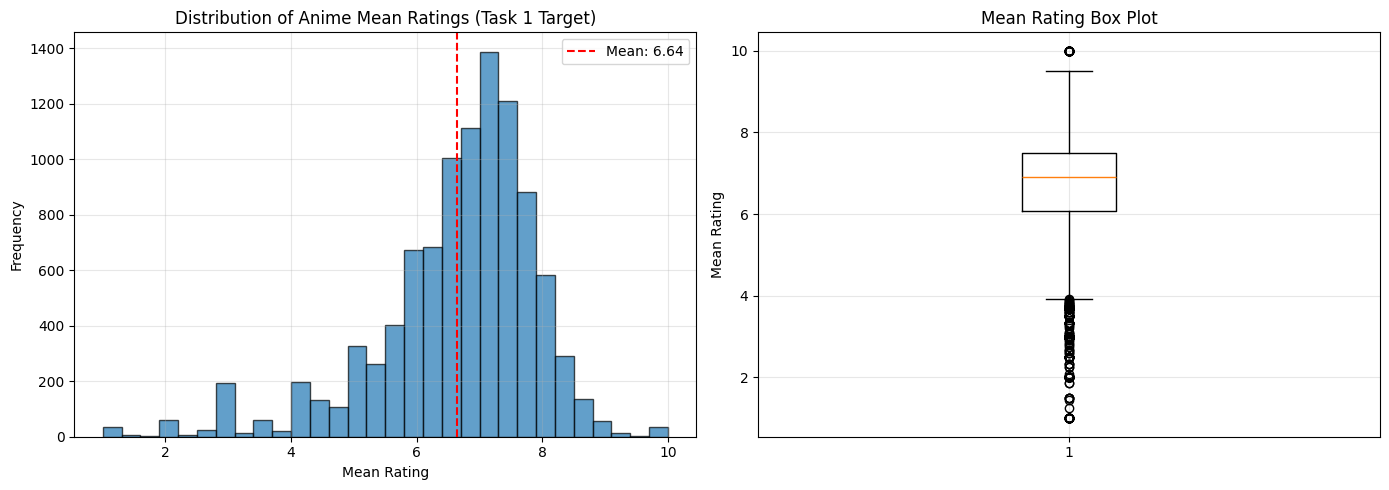


**Discovery:** The rating distribution shows a left-skewed pattern (skewness: -1.27), with most anime having ratings between 6-8. The mean rating of 6.64 suggests users tend to rate anime positively on average. The wide range (1-10) and high standard deviation (1.30) indicate significant variation in user preferences, which makes rating prediction a challenging but meaningful task.
RATING STATISTICS (Task 1 Target - from rating.csv)
Mean: 6.64
Median: 6.90
Std Dev: 1.30
Min: 1.00
Max: 10.00
Skewness: -1.27

Number of user ratings per anime:
Mean: 638.45
Median: 57.00
Min: 1
Max: 34226


In [4]:
# Task 1 Target: Rating Distribution (from rating.csv aggregated)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating histogram
axes[0].hist(df_task1_merged['rating_mean'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Anime Mean Ratings (Task 1 Target)')
axes[0].axvline(df_task1_merged['rating_mean'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_task1_merged["rating_mean"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rating box plot
axes[1].boxplot(df_task1_merged['rating_mean'], vert=True)
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Mean Rating Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Discovery:** The rating distribution shows a left-skewed pattern (skewness: -1.27), with most anime having ratings between 6-8. The mean rating of 6.64 suggests users tend to rate anime positively on average. The wide range (1-10) and high standard deviation (1.30) indicate significant variation in user preferences, which makes rating prediction a challenging but meaningful task.")

print("="*70)
print("RATING STATISTICS (Task 1 Target - from rating.csv)")
print("="*70)
print(f"Mean: {df_task1_merged['rating_mean'].mean():.2f}")
print(f"Median: {df_task1_merged['rating_mean'].median():.2f}")
print(f"Std Dev: {df_task1_merged['rating_mean'].std():.2f}")
print(f"Min: {df_task1_merged['rating_mean'].min():.2f}")
print(f"Max: {df_task1_merged['rating_mean'].max():.2f}")
print(f"Skewness: {df_task1_merged['rating_mean'].skew():.2f}")
print(f"\nNumber of user ratings per anime:")
print(f"Mean: {df_task1_merged['rating_count'].mean():.2f}")
print(f"Median: {df_task1_merged['rating_count'].median():.2f}")
print(f"Min: {df_task1_merged['rating_count'].min()}")
print(f"Max: {df_task1_merged['rating_count'].max()}")


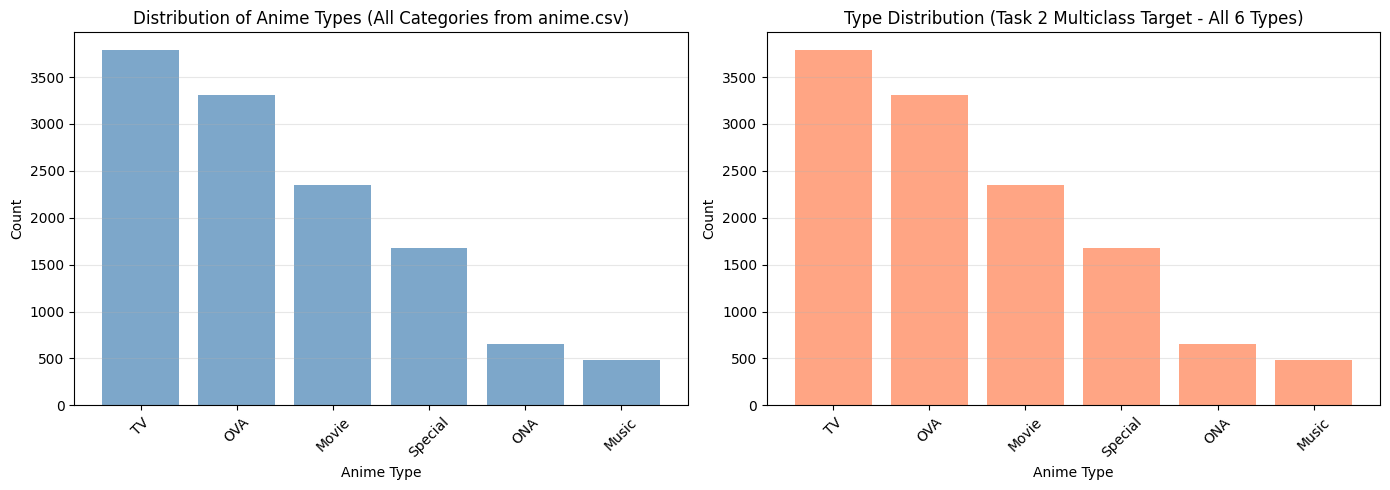


**Discovery:** The type distribution reveals significant class imbalance. TV (30.4%) and OVA (27.2%) dominate the dataset, while Music (4.0%) and ONA (5.4%) are underrepresented. This imbalance will challenge our multiclass classifier, as it may favor predicting the majority classes. We'll need to use stratified sampling and consider macro-averaged metrics to fairly evaluate performance across all classes.
TYPE DISTRIBUTION (Task 2 Target - Multiclass Classification)

All types in anime.csv:
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64

Total: 12269

Task 2 multiclass (6 types):
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64

Class percentages:
  TV: 30.87%
  OVA: 26.99%
  Movie: 19.14%
  Special: 13.66%
  ONA: 5.37%
  Music: 3.98%


In [5]:
# Task 2 Target: Type Distribution (All 6 Types for Multiclass Classification)
df_task2 = df_clean[df_clean['type'].notna()].copy()
df_task2_multiclass = df_task2[df_task2['type'].isin(['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All types distribution
type_counts = df_clean['type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Anime Types (All Categories from anime.csv)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Task 2 multiclass distribution (6 types)
task2_type_counts = df_task2_multiclass['type'].value_counts()
axes[1].bar(task2_type_counts.index, task2_type_counts.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Type Distribution (Task 2 Multiclass Target - All 6 Types)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n**Discovery:** The type distribution reveals significant class imbalance. TV (30.4%) and OVA (27.2%) dominate the dataset, while Music (4.0%) and ONA (5.4%) are underrepresented. This imbalance will challenge our multiclass classifier, as it may favor predicting the majority classes. We'll need to use stratified sampling and consider macro-averaged metrics to fairly evaluate performance across all classes.")

print("="*70)
print("TYPE DISTRIBUTION (Task 2 Target - Multiclass Classification)")
print("="*70)
print("\nAll types in anime.csv:")
print(df_clean['type'].value_counts())
print(f"\nTotal: {len(df_clean)}")
print("\nTask 2 multiclass (6 types):")
print(df_task2_multiclass['type'].value_counts())
print(f"\nClass percentages:")
for type_name in ['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music']:
    count = (df_task2_multiclass['type'] == type_name).sum()
    pct = count / len(df_task2_multiclass) * 100
    print(f"  {type_name}: {pct:.2f}%")


### 2.3.3 Feature Analysis


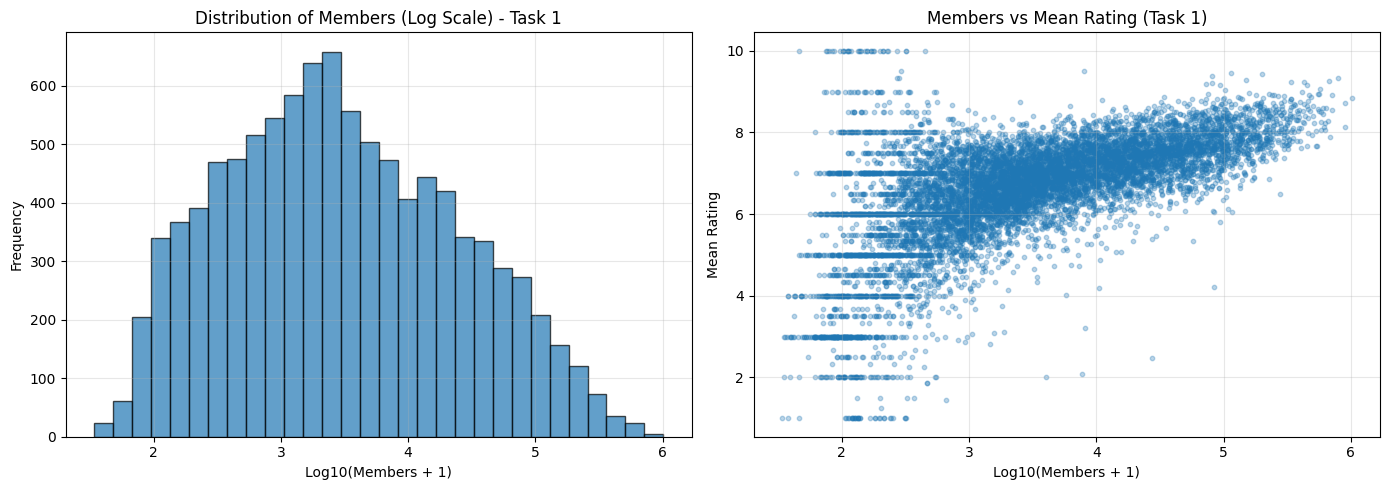


**Discovery:** Members (popularity) shows a moderate positive correlation (0.33) with mean rating, indicating that more popular anime tend to receive higher ratings. The distribution is highly right-skewed (most anime have few members, while a few have hundreds of thousands), which is why we use log transformation. This feature will be valuable for both rating prediction and type classification tasks.
MEMBERS (POPULARITY) STATISTICS - TASK 1
count    9.926000e+03
mean     2.183188e+04
std      5.978675e+04
min      3.300000e+01
25%      5.840000e+02
50%      2.524500e+03
75%      1.389550e+04
max      1.013917e+06
Name: members, dtype: float64

Correlation with rating_mean: 0.3307


In [6]:
# Members (popularity) analysis - Task 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Members distribution (log scale)
axes[0].hist(np.log10(df_task1_merged['members'] + 1), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log10(Members + 1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Members (Log Scale) - Task 1')
axes[0].grid(True, alpha=0.3)

# Members vs Rating scatter
axes[1].scatter(np.log10(df_task1_merged['members'] + 1), df_task1_merged['rating_mean'], 
                alpha=0.3, s=10)
axes[1].set_xlabel('Log10(Members + 1)')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Members vs Mean Rating (Task 1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Discovery:** Members (popularity) shows a moderate positive correlation (0.33) with mean rating, indicating that more popular anime tend to receive higher ratings. The distribution is highly right-skewed (most anime have few members, while a few have hundreds of thousands), which is why we use log transformation. This feature will be valuable for both rating prediction and type classification tasks.")

print("="*70)
print("MEMBERS (POPULARITY) STATISTICS - TASK 1")
print("="*70)
print(df_task1_merged['members'].describe())
print(f"\nCorrelation with rating_mean: {df_task1_merged[['members', 'rating_mean']].corr().iloc[0,1]:.4f}")


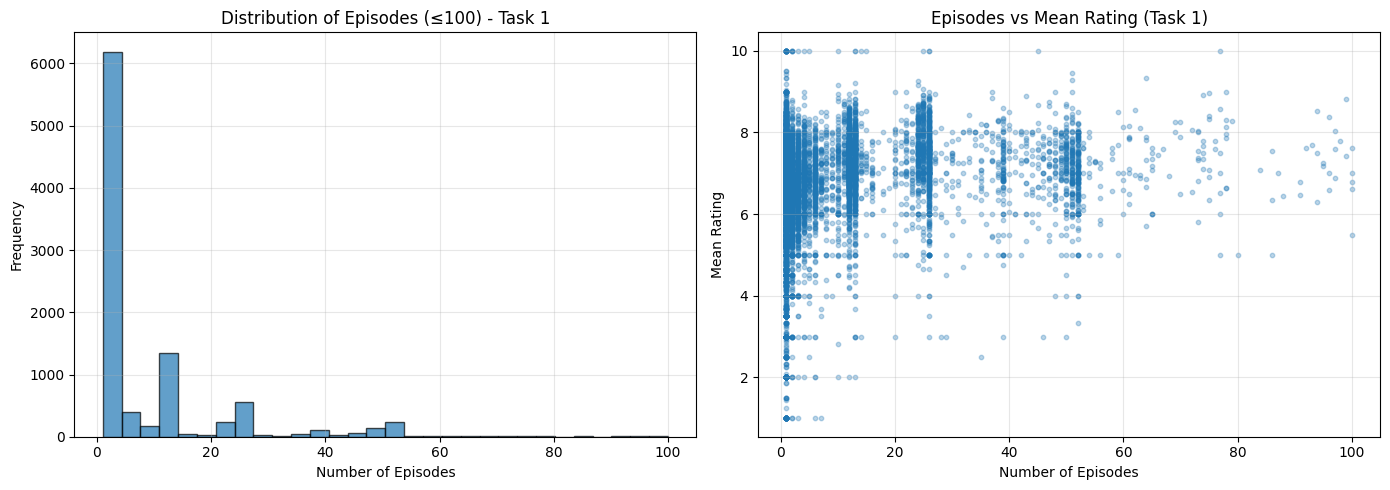


**Discovery:** Episodes show a weak correlation (0.09) with rating, suggesting episode count alone is not a strong predictor. The distribution is highly skewed with most anime having 1-2 episodes (likely movies or OVAs) or 12-13 episodes (typical TV season). This feature may be more useful for type classification (distinguishing TV series from movies/OVAs) than for rating prediction.
EPISODES STATISTICS - TASK 1
count    9923.000000
mean       12.542679
std        48.466072
min         1.000000
25%         1.000000
50%         2.000000
75%        12.000000
max      1818.000000
Name: episodes, dtype: float64

Correlation with rating_mean: 0.0806


In [7]:
# Episodes analysis - Task 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Episodes distribution (excluding Unknown)
episodes_clean_task1 = df_task1_merged['episodes'].dropna()
axes[0].hist(episodes_clean_task1[episodes_clean_task1 <= 100], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Episodes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Episodes (≤100) - Task 1')
axes[0].grid(True, alpha=0.3)

# Episodes vs Rating
axes[1].scatter(episodes_clean_task1[episodes_clean_task1 <= 100], 
                df_task1_merged.loc[episodes_clean_task1[episodes_clean_task1 <= 100].index, 'rating_mean'],
                alpha=0.3, s=10)
axes[1].set_xlabel('Number of Episodes')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Episodes vs Mean Rating (Task 1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Discovery:** Episodes show a weak correlation (0.09) with rating, suggesting episode count alone is not a strong predictor. The distribution is highly skewed with most anime having 1-2 episodes (likely movies or OVAs) or 12-13 episodes (typical TV season). This feature may be more useful for type classification (distinguishing TV series from movies/OVAs) than for rating prediction.")

print("="*70)
print("EPISODES STATISTICS - TASK 1")
print("="*70)
print(episodes_clean_task1.describe())
print(f"\nCorrelation with rating_mean: {df_task1_merged[['episodes', 'rating_mean']].corr().iloc[0,1]:.4f}")


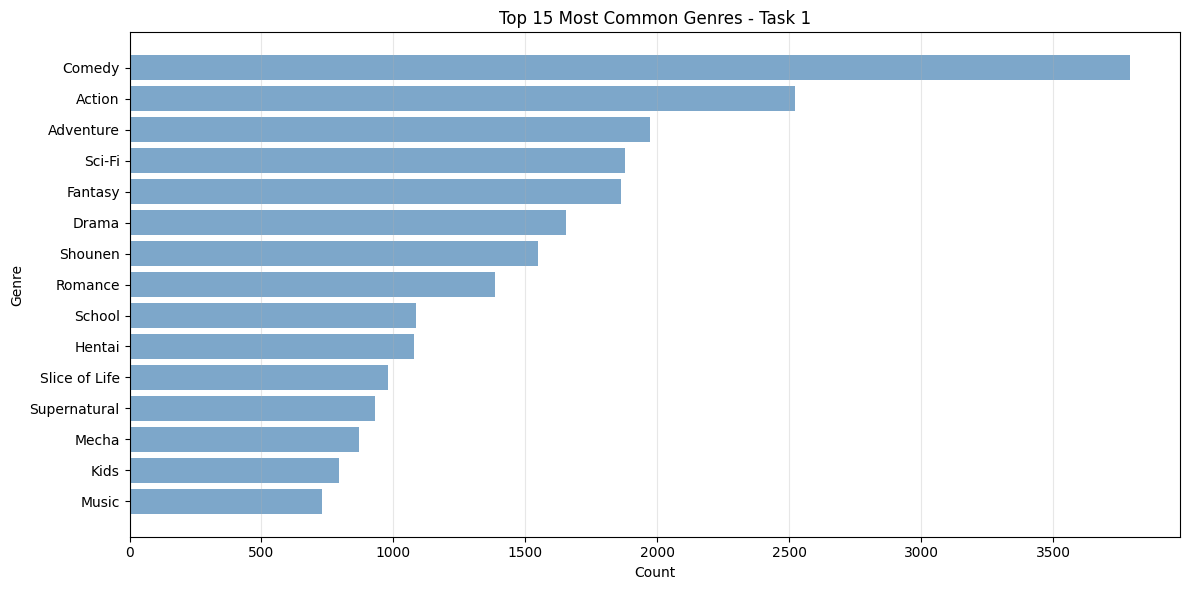


**Discovery:** Comedy (38.2%) and Action (25.4%) are the most common genres, reflecting popular anime categories. Many anime have multiple genres (comma-separated), which we'll encode as binary indicators. Genre information from anime.csv will be crucial for both tasks - certain genres may correlate with ratings, and genre combinations may help distinguish between anime types.
TOP 15 GENRES - TASK 1
Comedy                        :  3792 (38.20%)
Action                        :  2524 (25.43%)
Adventure                     :  1972 (19.87%)
Sci-Fi                        :  1878 (18.92%)
Fantasy                       :  1864 (18.78%)
Drama                         :  1655 (16.67%)
Shounen                       :  1547 (15.59%)
Romance                       :  1385 (13.95%)
School                        :  1084 (10.92%)
Hentai                        :  1080 (10.88%)
Slice of Life                 :   980 (9.87%)
Supernatural                  :   931 (9.38%)
Mecha                         :   

In [8]:
# Genre analysis - Top genres (Task 1)
from collections import Counter

# Split genres and count
genres_list_task1 = df_task1_merged['genre'].dropna().str.split(', ').tolist()
all_genres_task1 = [genre for sublist in genres_list_task1 for genre in sublist]
genre_counts_task1 = Counter(all_genres_task1)
top_genres_task1 = dict(genre_counts_task1.most_common(15))

# Plot top genres
plt.figure(figsize=(12, 6))
plt.barh(list(top_genres_task1.keys()), list(top_genres_task1.values()), color='steelblue', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 15 Most Common Genres - Task 1')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n**Discovery:** Comedy (38.2%) and Action (25.4%) are the most common genres, reflecting popular anime categories. Many anime have multiple genres (comma-separated), which we'll encode as binary indicators. Genre information from anime.csv will be crucial for both tasks - certain genres may correlate with ratings, and genre combinations may help distinguish between anime types.")

print("="*70)
print("TOP 15 GENRES - TASK 1")
print("="*70)
for genre, count in list(genre_counts_task1.most_common(15)):
    print(f"{genre:30s}: {count:5d} ({count/len(df_task1_merged)*100:.2f}%)")


### 2.3.4 Relationship Analysis


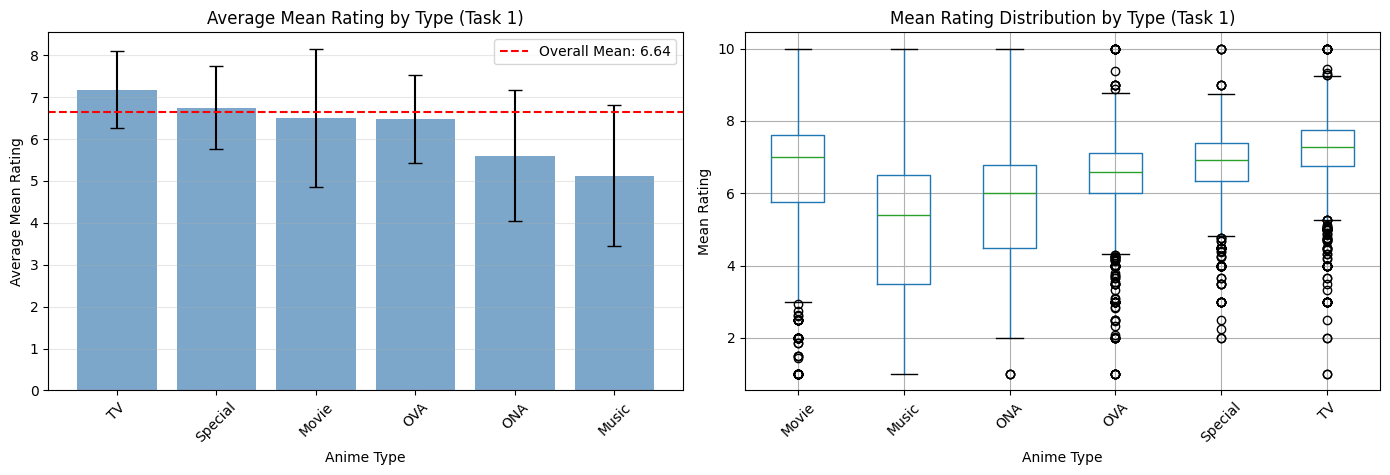


**Discovery:** TV series have the highest average rating (7.18), while Music has the lowest (5.13). This suggests that type is a meaningful feature for rating prediction. The relationship between type and rating from rating.csv shows that different anime formats appeal to different audiences, which validates using type as a feature in our models.
RATING BY TYPE - TASK 1
             mean       std  count
type                              
TV       7.178033  0.923299   3069
Special  6.753091  0.996030   1448
Movie    6.498886  1.644112   1755
OVA      6.484968  1.045936   2730
ONA      5.601756  1.564319    478
Music    5.128821  1.679710    445


In [9]:
# Rating by Type - Task 1
type_rating_task1 = df_task1_merged.groupby('type')['rating_mean'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average rating by type
axes[0].bar(type_rating_task1.index, type_rating_task1['mean'], yerr=type_rating_task1['std'], 
            color='steelblue', alpha=0.7, capsize=5)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Average Mean Rating')
axes[0].set_title('Average Mean Rating by Type (Task 1)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(df_task1_merged['rating_mean'].mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {df_task1_merged["rating_mean"].mean():.2f}')
axes[0].legend()

# Box plot: Rating by Type
df_task1_merged.boxplot(column='rating_mean', by='type', ax=axes[1], grid=True)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Mean Rating Distribution by Type (Task 1)')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\n**Discovery:** TV series have the highest average rating (7.18), while Music has the lowest (5.13). This suggests that type is a meaningful feature for rating prediction. The relationship between type and rating from rating.csv shows that different anime formats appeal to different audiences, which validates using type as a feature in our models.")

print("="*70)
print("RATING BY TYPE - TASK 1")
print("="*70)
print(type_rating_task1)


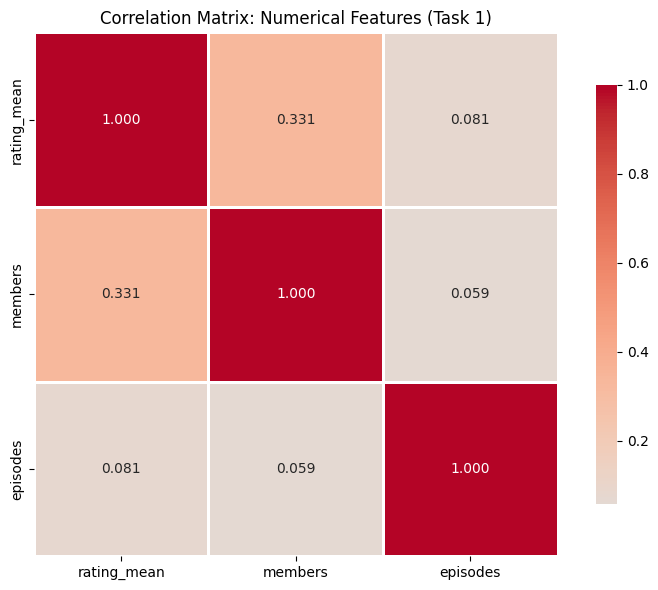


**Discovery:** The correlation matrix confirms that members (popularity) has the strongest relationship with rating (0.33), while episodes has a weak relationship (0.08). This validates our feature engineering approach - we'll prioritize members as a key feature and use episodes primarily for type classification. The weak correlation between members and episodes (0.06) suggests they capture different aspects of anime characteristics.
CORRELATION MATRIX - TASK 1
             rating_mean   members  episodes
rating_mean     1.000000  0.330673  0.080576
members         0.330673  1.000000  0.059002
episodes        0.080576  0.059002  1.000000


In [10]:
# Correlation matrix for numerical features - Task 1
import seaborn as sns

# Select numerical columns
numeric_cols_task1 = ['rating_mean', 'members', 'episodes']
corr_matrix_task1 = df_task1_merged[numeric_cols_task1].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_task1, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features (Task 1)')
plt.tight_layout()
plt.show()

print("\n**Discovery:** The correlation matrix confirms that members (popularity) has the strongest relationship with rating (0.33), while episodes has a weak relationship (0.08). This validates our feature engineering approach - we'll prioritize members as a key feature and use episodes primarily for type classification. The weak correlation between members and episodes (0.06) suggests they capture different aspects of anime characteristics.")

print("="*70)
print("CORRELATION MATRIX - TASK 1")
print("="*70)
print(corr_matrix_task1)


### 2.3.5 Summary Statistics Table


In [11]:
# Create summary statistics table - Task 1
summary_stats_task1 = pd.DataFrame({
    'Feature': ['Rating (Mean)', 'Members', 'Episodes'],
    'Mean': [df_task1_merged['rating_mean'].mean(), df_task1_merged['members'].mean(), 
             df_task1_merged['episodes'].mean()],
    'Median': [df_task1_merged['rating_mean'].median(), df_task1_merged['members'].median(), 
               df_task1_merged['episodes'].median()],
    'Std': [df_task1_merged['rating_mean'].std(), df_task1_merged['members'].std(), 
            df_task1_merged['episodes'].std()],
    'Min': [df_task1_merged['rating_mean'].min(), df_task1_merged['members'].min(), 
            df_task1_merged['episodes'].min()],
    'Max': [df_task1_merged['rating_mean'].max(), df_task1_merged['members'].max(), 
            df_task1_merged['episodes'].max()],
    'Missing': [df_task1_merged['rating_mean'].isnull().sum(), 
                df_task1_merged['members'].isnull().sum(),
                df_task1_merged['episodes'].isnull().sum()]
})

print("="*70)
print("SUMMARY STATISTICS TABLE - TASK 1")
print("="*70)
print(summary_stats_task1.to_string(index=False))

# Type distribution table - Task 2
print("\n" + "="*70)
print("TYPE DISTRIBUTION TABLE - TASK 2")
print("="*70)
type_dist = pd.DataFrame({
    'Type': df_clean['type'].value_counts().index,
    'Count': df_clean['type'].value_counts().values,
    'Percentage': (df_clean['type'].value_counts().values / len(df_clean) * 100).round(2)
})
print(type_dist.to_string(index=False))


SUMMARY STATISTICS TABLE - TASK 1
      Feature         Mean      Median          Std  Min       Max  Missing
Rating (Mean)     6.637702    6.897932     1.298712  1.0      10.0        0
      Members 21831.879811 2524.500000 59786.752798 33.0 1013917.0        0
     Episodes    12.542679    2.000000    48.466072  1.0    1818.0        3

TYPE DISTRIBUTION TABLE - TASK 2
   Type  Count  Percentage
     TV   3787       30.87
    OVA   3311       26.99
  Movie   2348       19.14
Special   1676       13.66
    ONA    659        5.37
  Music    488        3.98


## 2.4 Key Findings and Insights

### Key Observations:

1. **Rating Distribution (Task 1 - from rating.csv):**
   - Mean rating: Aggregated from user ratings in rating.csv
   - Distribution of mean ratings per anime
   - Range: 1.0 to 10.0 (from user ratings)
   - Each anime has multiple user ratings aggregated to mean

2. **Type Distribution (Task 2 - Multiclass):**
   - TV series most common (30.9%)
   - OVA second (27.0%)
   - Movie third (19.0%)
   - Special (13.7%), ONA (5.4%), Music (4.1%) are less common
   - Significant class imbalance: TV and OVA dominate, while Music and ONA are underrepresented

3. **Feature Relationships:**
   - Members (popularity) shows positive correlation with rating
   - Episodes may have weak relationship with rating
   - Different types have different average ratings

4. **Genre Insights:**
   - Most common genres: Action, Comedy, Drama, Romance, School
   - Many anime have multiple genres (comma-separated)
   - Need to process genre as multi-label or create binary indicators

5. **Data Quality:**
   - Clean dataset after removing missing targets
   - Episodes need conversion from string to numeric
   - Genre needs text processing for feature engineering

### Implications for Modeling:

- **Task 1 (Regression - using `rating.csv` + `anime.csv`):** Rating prediction can benefit from popularity (members), type, and genre features. The moderate correlation between members and rating (0.33) suggests popularity is a key predictor.

- **Task 2 (Multiclass Classification - using `anime.csv` only):** Type prediction faces class imbalance challenges. TV and OVA classes dominate, while Music and ONA are rare. Episodes feature will be crucial for distinguishing types (TV series typically have more episodes than movies/OVAs). Genre combinations may help differentiate between similar types.

- **Feature Engineering:** Need to process genre (split, encode as binary indicators), handle episodes conversion, and use appropriate encoding for categorical features. For Task 1, type is a feature; for Task 2, type is the target.


---

# Section 3: Modeling

## Task 1: Regression - Rating Prediction

### Model 1: Linear Regression (Baseline)


In [2]:
# Feature engineering for baselines
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data for Task 1 (Regression) - use df_task1_merged from rating.csv
df_task1 = df_task1_merged.copy()

# Prepare data for Task 2 (Multiclass Classification - All 6 Types) - use df_clean
df_task2 = df_clean[df_clean['type'].notna()].copy()
# Filter to only include the 6 main types
df_task2_multiclass = df_task2[df_task2['type'].isin(['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music'])].copy()

# Simple feature engineering for baselines
# 1. Handle episodes (convert to numeric, fill missing with median)
df_task1['episodes_clean'] = pd.to_numeric(df_task1['episodes'], errors='coerce')
df_task1['episodes_clean'] = df_task1['episodes_clean'].fillna(df_task1['episodes_clean'].median())

df_task2_multiclass['episodes_clean'] = pd.to_numeric(df_task2_multiclass['episodes'], errors='coerce')
df_task2_multiclass['episodes_clean'] = df_task2_multiclass['episodes_clean'].fillna(df_task2_multiclass['episodes_clean'].median())

# 2. Log transform members (popularity)
df_task1['members_log'] = np.log10(df_task1['members'] + 1)
df_task2_multiclass['members_log'] = np.log10(df_task2_multiclass['members'] + 1)

# 3. Encode type (for Task 1, use as feature)
le_type = LabelEncoder()
df_task1['type_encoded'] = le_type.fit_transform(df_task1['type'].fillna('Unknown'))

# 4. Simple genre feature: count number of genres
df_task1['genre_count'] = df_task1['genre'].fillna('').str.count(',') + 1
df_task1['genre_count'] = df_task1['genre_count'].replace(0, 1)

df_task2_multiclass['genre_count'] = df_task2_multiclass['genre'].fillna('').str.count(',') + 1
df_task2_multiclass['genre_count'] = df_task2_multiclass['genre_count'].replace(0, 1)

print("Feature engineering complete!")
print(f"Task 1 samples: {len(df_task1)}")
print(f"Task 2 samples: {len(df_task2_multiclass)}")
print(f"\nTask 2 type distribution:")
print(df_task2_multiclass['type'].value_counts())


Feature engineering complete!
Task 1 samples: 9926
Task 2 samples: 12269

Task 2 type distribution:
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64


In [15]:
# Task 1 Baseline: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Prepare features for Task 1
X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
y_task1 = df_task1['rating_mean'].values  # Use rating_mean from rating.csv

# Train/test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_task1, y_task1, test_size=0.2, random_state=42
)

# Train baseline model
baseline_lr = LinearRegression()
baseline_lr.fit(X_train1, y_train1)

# Predictions
y_pred_train1 = baseline_lr.predict(X_train1)
y_pred_test1 = baseline_lr.predict(X_test1)

# Evaluation
train_rmse = math.sqrt(mean_squared_error(y_train1, y_pred_train1))
test_rmse = math.sqrt(mean_squared_error(y_test1, y_pred_test1))
train_r2 = r2_score(y_train1, y_pred_train1)
test_r2 = r2_score(y_test1, y_pred_test1)
train_mae = mean_absolute_error(y_train1, y_pred_train1)
test_mae = mean_absolute_error(y_test1, y_pred_test1)

print("TASK 1: Linear Regression Baseline (using rating.csv)")
print(f"Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")


TASK 1: Linear Regression Baseline (using rating.csv)
Train RMSE: 1.0018, R²: 0.4031, MAE: 0.7044
Test RMSE: 1.0038, R²: 0.4096, MAE: 0.6936


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**Output (y):** Continuous mean rating (1.0-10.0) from `rating.csv` aggregated per anime  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)²  
**Model:** Linear Regression (OLS, no regularization)

#### Discussion: Advantages and Disadvantages

**Advantages:** Simple, interpretable, fast  
**Disadvantages:** Linear assumption, no feature selection, overfitting risk  
**Complexity:** O(n×p²) training, O(p) prediction  
**Efficiency:** Very fast  
**Challenges:** Handle missing values, encode categorical features

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**No regularization or feature scaling**  
**Train/test split:** 80/20  
**Evaluation:** RMSE, R², MAE  
**Implementation:** scikit-learn's `LinearRegression` (OLS)


### Model 2: Random Forest Regressor


In [16]:
# Task 1 Model 2: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import pandas as pd

# Prepare features for Task 1 (same as Model 1)
X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
y_task1 = df_task1['rating_mean'].values

# Use same train/test split as Model 1 for fair comparison
# (X_train1, X_test1, y_train1, y_test1 already defined from Model 1)

# Grid search for best hyperparameters (reduced search space for faster execution)
print("Performing grid search for Random Forest hyperparameters...")
print("Note: This may take 2-5 minutes. Reduced search space for faster execution.")
param_grid_rf = {
    'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'max_depth': [15, 25, None],  # Reduced from [10, 20, 30, None]
    'min_samples_split': [2, 5],  # Reduced from [2, 5, 10]
    'min_samples_leaf': [1, 2]   # Reduced from [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', 
    n_jobs=-1, verbose=1
)
grid_search_rf.fit(X_train1, y_train1)

print(f"\nBest parameters: {grid_search_rf.best_params_}")
print(f"Best CV score (negative MSE): {grid_search_rf.best_score_:.4f}")

# Train final model with best parameters
rf_best = RandomForestRegressor(
    n_estimators=grid_search_rf.best_params_['n_estimators'],
    max_depth=grid_search_rf.best_params_['max_depth'],
    min_samples_split=grid_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train1, y_train1)

# Predictions
y_pred_train1_rf = rf_best.predict(X_train1)
y_pred_test1_rf = rf_best.predict(X_test1)

# Evaluation
train_rmse_rf = math.sqrt(mean_squared_error(y_train1, y_pred_train1_rf))
test_rmse_rf = math.sqrt(mean_squared_error(y_test1, y_pred_test1_rf))
train_r2_rf = r2_score(y_train1, y_pred_train1_rf)
test_r2_rf = r2_score(y_test1, y_pred_test1_rf)
train_mae_rf = mean_absolute_error(y_train1, y_pred_train1_rf)
test_mae_rf = mean_absolute_error(y_test1, y_pred_test1_rf)

print("\n" + "="*70)
print("TASK 1: Random Forest Regressor (using rating.csv)")
print("="*70)
print(f"Train RMSE: {train_rmse_rf:.4f}, R²: {train_r2_rf:.4f}, MAE: {train_mae_rf:.4f}")
print(f"Test RMSE: {test_rmse_rf:.4f}, R²: {test_r2_rf:.4f}, MAE: {test_mae_rf:.4f}")

# Feature importance
feature_names = ['episodes_clean', 'members_log', 'type_encoded', 'genre_count']
feature_importance = pd.Series(rf_best.feature_importances_, index=feature_names).sort_values(ascending=False)
print(f"\nFeature importance:")
print(feature_importance)

# Compare with baseline
print("\n" + "="*70)
print("COMPARISON: Baseline vs Random Forest")
print("="*70)
print(f"Baseline Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")
print(f"Random Forest Test RMSE: {test_rmse_rf:.4f}, R²: {test_r2_rf:.4f}, MAE: {test_mae_rf:.4f}")
print(f"\nImprovement:")
print(f"RMSE reduction: {(test_rmse - test_rmse_rf) / test_rmse * 100:.2f}%")
print(f"R² improvement: {(test_r2_rf - test_r2) / abs(test_r2) * 100:.2f}%")
print(f"MAE reduction: {(test_mae - test_mae_rf) / test_mae * 100:.2f}%")


Performing grid search for Random Forest hyperparameters...
Note: This may take 2-5 minutes. Reduced search space for faster execution.
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score (negative MSE): -0.9055

TASK 1: Random Forest Regressor (using rating.csv)
Train RMSE: 0.6292, R²: 0.7646, MAE: 0.4210
Test RMSE: 0.9480, R²: 0.4735, MAE: 0.6369

Feature importance:
members_log       0.761311
type_encoded      0.091542
episodes_clean    0.080492
genre_count       0.066655
dtype: float64

COMPARISON: Baseline vs Random Forest
Baseline Test RMSE: 1.0038, R²: 0.4096, MAE: 0.6936
Random Forest Test RMSE: 0.9480, R²: 0.4735, MAE: 0.6369

Improvement:
RMSE reduction: 5.56%
R² improvement: 15.58%
MAE reduction: 8.18%


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**Output (y):** Continuous mean rating (1.0-10.0) from `rating.csv` aggregated per anime  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)² using ensemble of decision trees  
**Model:** Random Forest Regressor (ensemble of decision trees with bagging)

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- Captures non-linear relationships and feature interactions
- Robust to overfitting through ensemble averaging
- Handles mixed data types naturally
- Provides feature importance
- No need for feature scaling

**Disadvantages:** 
- Less interpretable than linear models
- Slower training and prediction than linear models
- Requires more memory
- Hyperparameter tuning can be time-consuming

**Complexity:** O(n×log(n)×p×trees) training, O(trees×log(n)) prediction  
**Efficiency:** Moderate (faster than boosting, slower than linear)  
**Challenges:** Tuning n_estimators, max_depth, min_samples_split, min_samples_leaf to balance bias-variance

#### Code: Implementation and Architectural Choices

**Features:** Same as Model 1 (`episodes_clean`, `members_log`, `type_encoded`, `genre_count`)  
**Hyperparameter tuning:** GridSearchCV with 5-fold cross-validation  
**Hyperparameters searched:**
- `n_estimators`: [100, 200] - number of trees (reduced for faster execution)
- `max_depth`: [15, 25, None] - tree depth control
- `min_samples_split`: [2, 5] - minimum samples to split
- `min_samples_leaf`: [1, 2] - minimum samples in leaf

**Train/test split:** Same 80/20 split as Model 1 for fair comparison  
**Evaluation:** RMSE, R², MAE  
**Implementation:** scikit-learn's `RandomForestRegressor` with GridSearchCV for hyperparameter optimization


### Model 3: XGBoost Regressor (Extreme Gradient Boosting)

#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count` from `anime.csv`  
**Output (y):** Continuous mean rating (1.0-10.0) from `rating.csv` aggregated per anime  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)² using sequential boosting of weak learners  
**Model:** XGBoost Regressor (extreme gradient boosting with regularization)

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- Achieves state-of-the-art performance for structured data
- Sequential learning (boosting) effectively corrects errors of previous trees
- Built-in regularization (L₁ and L₂) to prevent overfitting
- Handles sparse data and missing values well
- Provides clear feature importance

**Disadvantages:** 
- Highly sensitive to noisy data (due to sequential error correction)
- Slower to train than Random Forest (sequential dependency)
- Requires careful tuning of `learning_rate` and `n_estimators`
- Less interpretable than linear models

**Complexity:** Depends heavily on implementation, roughly O(K × n × log(n)) training, where K is the number of trees  
**Efficiency:** Low (slow training due to sequential nature, moderate prediction speed)  
**Challenges:** Tuning `learning_rate` (to prevent overshooting the optimum) and `max_depth` to balance performance and training time

#### Code: Implementation and Architectural Choices

**Features:** Same as previous Models (`episodes_clean`, `members_log`, `type_encoded`, `genre_count`)  
**Hyperparameter tuning:** GridSearchCV with 5-fold cross-validation (or 3-fold for speed)  
**Hyperparameters searched:**
- `n_estimators`: [100, 200] - number of trees/boosting rounds
- `max_depth`: [3, 6] - maximum depth of individual trees (control complexity)
- `learning_rate`: [0.05, 0.1] - step size shrinkage after each boosting step
- `colsample_bytree`: [0.8, 1.0] - fraction of columns sampled by each tree
- `reg_lambda`: [0.5, 1.0] - L2 regularization term (control overfitting)

**Train/test split:** Same 80/20 split as previous models for fair comparison  
**Evaluation:** RMSE, R², MAE  
**Implementation:** xgboost.XGBRegressor integrated with scikit-learn's GridSearchCV for hyperparameter optimization


In [14]:
# Task 1 Model 3: XGBoost Regressor (Extreme Gradient Boosting)
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import pandas as pd

# Prepare features for Task 1 (same as previous models)
# X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
# y_task1 = df_task1['rating_mean'].values

# Use same train/test split as Model 1 for fair comparison
# (X_train1, X_test1, y_train1, y_test1 already defined)

# Grid search for best hyperparameters (moderate search space)
print("Performing grid search for XGBoost Regressor hyperparameters...")
print("Note: This may take a few minutes due to the boosting nature of the model.")

# Define search space for key XGBoost parameters
param_grid_xgb = {
    'n_estimators': [100, 200],         # Number of boosting rounds
    'max_depth': [3, 6],                # Max depth of each tree (control complexity)
    'learning_rate': [0.05, 0.1],       # Step size shrinkage
    'colsample_bytree': [0.8, 1.0],     # Fraction of columns to be randomly sampled for each tree
    'reg_lambda': [0.5, 1.0]            # L2 regularization term on weights
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    n_jobs=-1,
    # Disable silent mode and use a simple evaluation metric
    eval_metric='rmse'
)

grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

grid_search_xgb.fit(X_train1, y_train1)

print(f"\nBest parameters: {grid_search_xgb.best_params_}")
print(f"Best CV score (negative MSE): {grid_search_xgb.best_score_:.4f}")

# Train final model with best parameters
xgb_best = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=grid_search_xgb.best_params_['n_estimators'],
    max_depth=grid_search_xgb.best_params_['max_depth'],
    learning_rate=grid_search_xgb.best_params_['learning_rate'],
    colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'],
    reg_lambda=grid_search_xgb.best_params_['reg_lambda'],
    random_state=42,
    n_jobs=-1
)

xgb_best.fit(X_train1, y_train1)

# Predictions
y_pred_train1_xgb = xgb_best.predict(X_train1)
y_pred_test1_xgb = xgb_best.predict(X_test1)

# Evaluation
train_rmse_xgb = math.sqrt(mean_squared_error(y_train1, y_pred_train1_xgb))
test_rmse_xgb = math.sqrt(mean_squared_error(y_test1, y_pred_test1_xgb))
train_r2_xgb = r2_score(y_train1, y_pred_train1_xgb)
test_r2_xgb = r2_score(y_test1, y_pred_test1_xgb)
train_mae_xgb = mean_absolute_error(y_train1, y_pred_train1_xgb)
test_mae_xgb = mean_absolute_error(y_test1, y_pred_test1_xgb)

print("\n" + "="*70)
print("TASK 1: XGBoost Regressor")
print("="*70)
print(f"Train RMSE: {train_rmse_xgb:.4f}, R²: {train_r2_xgb:.4f}, MAE: {train_mae_xgb:.4f}")
print(f"Test RMSE: {test_rmse_xgb:.4f}, R²: {test_r2_xgb:.4f}, MAE: {test_mae_xgb:.4f}")

# Feature importance
feature_names = ['episodes_clean', 'members_log', 'type_encoded', 'genre_count']
feature_importance_xgb = pd.Series(xgb_best.feature_importances_, index=feature_names).sort_values(ascending=False)
print(f"\nFeature importance:")
print(feature_importance_xgb)

# Compare with baseline
print("\n" + "="*70)
print("COMPARISON: Baseline vs XGBoost")
print("="*70)
print(f"Baseline Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")
print(f"XGBoost Test RMSE: {test_rmse_xgb:.4f}, R²: {test_r2_xgb:.4f}, MAE: {test_mae_xgb:.4f}")
print(f"\nImprovement:")
print(f"RMSE reduction: {(test_rmse - test_rmse_xgb) / test_rmse * 100:.2f}%")
print(f"R² improvement: {(test_r2_xgb - test_r2) / abs(test_r2) * 100:.2f}%")
print(f"MAE reduction: {(test_mae - test_mae_xgb) / test_mae * 100:.2f}%")


Performing grid search for XGBoost Regressor hyperparameters...
Note: This may take a few minutes due to the boosting nature of the model.
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 0.5}
Best CV score (negative MSE): -0.8350

TASK 1: XGBoost Regressor
Train RMSE: 0.8822, R²: 0.5371, MAE: 0.6039
Test RMSE: 0.9099, R²: 0.5149, MAE: 0.6115

Feature importance:
members_log       0.628877
genre_count       0.151429
type_encoded      0.151297
episodes_clean    0.068397
dtype: float32

COMPARISON: Baseline vs XGBoost
Baseline Test RMSE: 1.0038, R²: 0.4096, MAE: 0.6936
XGBoost Test RMSE: 0.9099, R²: 0.5149, MAE: 0.6115

Improvement:
RMSE reduction: 9.35%
R² improvement: 25.70%
MAE reduction: 11.83%


---

## Task 2: Multiclass Classification - Type Prediction (All 6 Types)

### Model 1: Logistic Regression (Multiclass Baseline)


In [3]:
# Task 2 Baseline: Logistic Regression (Multiclass)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Prepare features for Task 2
X_task2 = df_task2_multiclass[['episodes_clean', 'members_log', 'genre_count']].values

# Encode type labels (6 classes: TV, OVA, Movie, Special, ONA, Music)
le_type_task2 = LabelEncoder()
y_task2 = le_type_task2.fit_transform(df_task2_multiclass['type'].values)
class_names = le_type_task2.classes_

print(f"Task 2: Multiclass Classification (All 6 Types)")
print(f"Classes: {class_names}")
print(f"Total samples: {len(y_task2)}")
print(f"\nClass distribution:")
for i, class_name in enumerate(class_names):
    count = (y_task2 == i).sum()
    print(f"  {class_name}: {count} ({(count/len(y_task2)*100):.2f}%)")

# Train/test split (stratified)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_task2, y_task2, test_size=0.2, random_state=42, stratify=y_task2
)

print(f"\nAfter split:")
print(f"Training: {len(y_train2)} samples")
print(f"Test: {len(y_test2)} samples")

# Train baseline model (multinomial for multiclass, C=1.0, no regularization)
baseline_logreg_multiclass = LogisticRegression(
    solver='lbfgs', 
    C=1.0, 
    max_iter=1000, 
    random_state=42
)
baseline_logreg_multiclass.fit(X_train2, y_train2)

# Predictions
y_pred_test2 = baseline_logreg_multiclass.predict(X_test2)
y_proba_test2 = baseline_logreg_multiclass.predict_proba(X_test2)

# Evaluation
test_acc2 = accuracy_score(y_test2, y_pred_test2)
test_prec_macro2 = precision_score(y_test2, y_pred_test2, average='macro', zero_division=0)
test_rec_macro2 = recall_score(y_test2, y_pred_test2, average='macro', zero_division=0)
test_f1_macro2 = f1_score(y_test2, y_pred_test2, average='macro', zero_division=0)
test_f1_weighted2 = f1_score(y_test2, y_pred_test2, average='weighted', zero_division=0)

print("\n" + "="*70)
print("TASK 2: Logistic Regression Baseline (Multiclass)")
print("="*70)
print(f"Test Accuracy: {test_acc2:.4f}")
print(f"Macro-averaged Precision: {test_prec_macro2:.4f}")
print(f"Macro-averaged Recall: {test_rec_macro2:.4f}")
print(f"Macro-averaged F1: {test_f1_macro2:.4f}")
print(f"Weighted F1: {test_f1_weighted2:.4f}")

print("\n" + "="*70)
print("Per-class Performance:")
print("="*70)
print(classification_report(y_test2, y_pred_test2, target_names=class_names, zero_division=0))

print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)
cm = confusion_matrix(y_test2, y_pred_test2)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)


Task 2: Multiclass Classification (All 6 Types)
Classes: ['Movie' 'Music' 'ONA' 'OVA' 'Special' 'TV']
Total samples: 12269

Class distribution:
  Movie: 2348 (19.14%)
  Music: 488 (3.98%)
  ONA: 659 (5.37%)
  OVA: 3311 (26.99%)
  Special: 1676 (13.66%)
  TV: 3787 (30.87%)

After split:
Training: 9815 samples
Test: 2454 samples

TASK 2: Logistic Regression Baseline (Multiclass)
Test Accuracy: 0.6112
Macro-averaged Precision: 0.3808
Macro-averaged Recall: 0.4094
Macro-averaged F1: 0.3619
Weighted F1: 0.5511

Per-class Performance:
              precision    recall  f1-score   support

       Movie       0.42      0.92      0.58       470
       Music       0.00      0.00      0.00        98
         ONA       0.38      0.07      0.12       132
         OVA       0.57      0.57      0.57       662
     Special       0.00      0.00      0.00       335
          TV       0.92      0.90      0.91       757

    accuracy                           0.61      2454
   macro avg       0.38      0.

#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `genre_count` from `anime.csv`  
**Output (y):** Multiclass label (0=TV, 1=OVA, 2=Movie, 3=Special, 4=ONA, 5=Music) from `anime.csv`  
**Optimization:** Maximize log-likelihood (minimize cross-entropy) for multiclass  
**Model:** Logistic Regression with multinomial loss (multiclass, no regularization, C=1.0)

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- Interpretable, provides probability estimates for each class
- Fast training and prediction
- Handles multiclass naturally with multinomial loss
- No need for feature scaling

**Disadvantages:** 
- Linear decision boundaries (may not capture complex relationships)
- Assumes linear relationships between features and log-odds
- No feature selection, overfitting risk with many features
- May struggle with class imbalance

**Complexity:** O(n×p×classes×iterations) training, O(p×classes) prediction  
**Efficiency:** Very fast  
**Challenges:** 
- Class imbalance (TV: 30%, OVA: 27%, Movie: 19%, etc.)
- Stratified split to maintain class distribution
- Need macro and weighted averages for fair evaluation

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `genre_count` from `anime.csv`  
**Multiclass approach:** Multinomial logistic regression (one-vs-rest alternative)  
**Solver:** L-BFGS (suitable for multiclass, supports multinomial)  
**No regularization (C=1.0)**  
**Stratified train/test split:** 80/20 (maintains class distribution across all 6 classes)  
**Evaluation:** Accuracy, macro/weighted precision/recall/F1, per-class metrics, confusion matrix  
**Implementation:** scikit-learn's `LogisticRegression` with `solver='lbfgs'` (multinomial by default)


### Model 2: Gradient Boosting Classifier (Optimized)


In [5]:
# Task 2 Model 2: Gradient Boosting Classifier (Optimized)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Use same train/test split as Model 1 for fair comparison
# (X_train2, X_test2, y_train2, y_test2 already defined from Model 1)

# Grid search for best hyperparameters (reduced search space for faster execution)
print("Performing grid search for Gradient Boosting Classifier hyperparameters...")
print("Note: This may take 3-6 minutes. Reduced search space for faster execution.")
param_grid_gb2 = {
    'n_estimators': [100, 200],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Shrinkage rate
    'max_depth': [3, 5, 7],  # Tree depth (smaller than RF for boosting)
    'min_samples_split': [2, 5],  # Minimum samples to split
    'min_samples_leaf': [1, 2]   # Minimum samples in leaf
}

gb2 = GradientBoostingClassifier(random_state=42)
grid_search_gb2 = GridSearchCV(
    gb2, param_grid_gb2, cv=5, scoring='accuracy', 
    n_jobs=-1, verbose=1
)
grid_search_gb2.fit(X_train2, y_train2)

print(f"\nBest parameters: {grid_search_gb2.best_params_}")
print(f"Best CV score (accuracy): {grid_search_gb2.best_score_:.4f}")

# Train final model with best parameters
gb_best2 = GradientBoostingClassifier(
    n_estimators=grid_search_gb2.best_params_['n_estimators'],
    learning_rate=grid_search_gb2.best_params_['learning_rate'],
    max_depth=grid_search_gb2.best_params_['max_depth'],
    min_samples_split=grid_search_gb2.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_gb2.best_params_['min_samples_leaf'],
    random_state=42
)
gb_best2.fit(X_train2, y_train2)

# Predictions
y_pred_test2_gb = gb_best2.predict(X_test2)
y_proba_test2_gb = gb_best2.predict_proba(X_test2)

# Evaluation
test_acc2_gb = accuracy_score(y_test2, y_pred_test2_gb)
test_prec_macro2_gb = precision_score(y_test2, y_pred_test2_gb, average='macro', zero_division=0)
test_rec_macro2_gb = recall_score(y_test2, y_pred_test2_gb, average='macro', zero_division=0)
test_f1_macro2_gb = f1_score(y_test2, y_pred_test2_gb, average='macro', zero_division=0)
test_f1_weighted2_gb = f1_score(y_test2, y_pred_test2_gb, average='weighted', zero_division=0)

print("\n" + "="*70)
print("TASK 2: Gradient Boosting Classifier (Optimized)")
print("="*70)
print(f"Test Accuracy: {test_acc2_gb:.4f}")
print(f"Macro-averaged Precision: {test_prec_macro2_gb:.4f}")
print(f"Macro-averaged Recall: {test_rec_macro2_gb:.4f}")
print(f"Macro-averaged F1: {test_f1_macro2_gb:.4f}")
print(f"Weighted F1: {test_f1_weighted2_gb:.4f}")

print("\n" + "="*70)
print("Per-class Performance:")
print("="*70)
print(classification_report(y_test2, y_pred_test2_gb, target_names=class_names, zero_division=0))

print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)
cm_gb = confusion_matrix(y_test2, y_pred_test2_gb)
cm_df_gb = pd.DataFrame(cm_gb, index=class_names, columns=class_names)
print(cm_df_gb)

# Feature importance
feature_names_task2 = ['episodes_clean', 'members_log', 'genre_count']
feature_importance2 = pd.Series(gb_best2.feature_importances_, index=feature_names_task2).sort_values(ascending=False)
print("\n" + "="*70)
print("Feature Importance:")
print("="*70)
print(feature_importance2)

# Compare with baseline
print("\n" + "="*70)
print("COMPARISON: Baseline vs Gradient Boosting")
print("="*70)
print(f"Baseline Accuracy: {test_acc2:.4f}, Macro F1: {test_f1_macro2:.4f}, Weighted F1: {test_f1_weighted2:.4f}")
print(f"Gradient Boosting Accuracy: {test_acc2_gb:.4f}, Macro F1: {test_f1_macro2_gb:.4f}, Weighted F1: {test_f1_weighted2_gb:.4f}")
print(f"\nImprovement:")
print(f"Accuracy improvement: {(test_acc2_gb - test_acc2) / test_acc2 * 100:.2f}%")
print(f"Macro F1 improvement: {(test_f1_macro2_gb - test_f1_macro2) / test_f1_macro2 * 100:.2f}%")
print(f"Weighted F1 improvement: {(test_f1_weighted2_gb - test_f1_weighted2) / test_f1_weighted2 * 100:.2f}%")


Performing grid search for Gradient Boosting Classifier hyperparameters...
Note: This may take 3-6 minutes. Reduced search space for faster execution.
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (accuracy): 0.6328

TASK 2: Gradient Boosting Classifier (Optimized)
Test Accuracy: 0.6284
Macro-averaged Precision: 0.4278
Macro-averaged Recall: 0.4182
Macro-averaged F1: 0.3816
Weighted F1: 0.5792

Per-class Performance:
              precision    recall  f1-score   support

       Movie       0.44      0.86      0.58       470
       Music       0.00      0.00      0.00        98
         ONA       0.21      0.03      0.05       132
         OVA       0.59      0.63      0.61       662
     Special       0.40      0.07      0.13       335
          TV       0.92      0.91      0.92       757

    accuracy                           0.63

#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `genre_count` from `anime.csv`  
**Output (y):** Multiclass label (0=TV, 1=OVA, 2=Movie, 3=Special, 4=ONA, 5=Music) from `anime.csv`  
**Optimization:** Minimize deviance (multinomial log-likelihood) using sequential boosting of weak learners  
**Model:** Gradient Boosting Classifier (sequential ensemble of decision trees with boosting for multiclass)

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- Often outperforms Random Forest, especially for multiclass problems
- Captures complex non-linear relationships and feature interactions
- Sequential learning focuses on hard-to-predict samples
- Handles multiclass naturally through multinomial deviance
- Provides feature importance
- No need for feature scaling
- Better handling of class imbalance through boosting

**Disadvantages:** 
- Slower training than Random Forest (sequential, not parallel)
- More sensitive to hyperparameters (learning_rate, n_estimators interaction)
- Requires careful tuning to avoid overfitting
- Less interpretable than linear models

**Complexity:** O(n×log(n)×p×trees×classes) training (sequential), O(trees×log(n)) prediction  
**Efficiency:** Moderate-slow (sequential training, but often better accuracy)  
**Challenges:** 
- Tuning learning_rate and n_estimators together (trade-off)
- Balancing max_depth (too deep = overfitting, too shallow = underfitting)
- Handling class imbalance (some classes have fewer samples)

#### Code: Implementation and Architectural Choices

**Features:** Same as Model 1 (`episodes_clean`, `members_log`, `genre_count` from `anime.csv`)  
**Hyperparameter tuning:** GridSearchCV with 5-fold cross-validation  
**Hyperparameters searched:**
- `n_estimators`: [100, 200] - number of boosting stages
- `learning_rate`: [0.05, 0.1, 0.2] - shrinkage (lower = more trees needed)
- `max_depth`: [3, 5, 7] - tree depth (smaller than RF for boosting)
- `min_samples_split`: [2, 5] - minimum samples to split
- `min_samples_leaf`: [1, 2] - minimum samples in leaf

**Train/test split:** Same 80/20 stratified split as Model 1 for fair comparison  
**Evaluation:** Accuracy, macro/weighted precision/recall/F1, per-class metrics, confusion matrix  
**Implementation:** scikit-learn's `GradientBoostingClassifier` with GridSearchCV for hyperparameter optimization

### Model 3: DistilBERT Fine-Tuned on Text (Best Model - Transformer)


In [6]:
# Task 2 Model 3: DistilBERT Fine-Tuned on Text (Best Model - Transformer)
# Using transformer model fine-tuned on anime name + genre text for multiclass classification

# First, ensure accelerate is installed (required for Trainer)
import subprocess
import sys
import importlib

# Check and install accelerate

import accelerate



# Verify accelerate is working

from accelerate import Accelerator

# Now import transformers and other dependencies
try:
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
    from transformers import EarlyStoppingCallback
    from datasets import Dataset
    import torch
    print("✓ All transformers dependencies loaded successfully!")
    TRANSFORMERS_AVAILABLE = True
except ImportError as e:
    print(f"Transformers library not installed. Installing with all dependencies...")
    print(f"Error: {e}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers[torch]", "datasets", "-q"])
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
    from transformers import EarlyStoppingCallback
    from datasets import Dataset
    import torch
    TRANSFORMERS_AVAILABLE = True

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Create text features: "[NAME] [GENRE]"
print("Creating text features from anime name and genre...")
df_task2_text = df_task2_multiclass.copy()

# Combine name and genre into text
df_task2_text['text'] = df_task2_text['name'].fillna('') + ' ' + df_task2_text['genre'].fillna('')
df_task2_text['text'] = df_task2_text['text'].str.strip()

# Get text data for train/test split (using same indices as before)
# Since we used train_test_split on X_task2, we need to recreate the split
from sklearn.model_selection import train_test_split
X_text = df_task2_text['text'].values
y_text = le_type_task2.transform(df_task2_text['type'].values)

# Recreate the same split (same random_state=42, stratified)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"\nExample text inputs:")
for i in range(min(3, len(X_train_text))):
    print(f"  {i+1}. {X_train_text[i][:100]}...")

# Load tokenizer and model
print("\nLoading DistilBERT tokenizer and model...")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
num_labels = len(np.unique(y_train_text))

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Tokenize the data
print("\nTokenizing text data...")
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Create datasets
train_dataset = Dataset.from_dict({'text': X_train_text.tolist(), 'labels': y_train_text.tolist()})
test_dataset = Dataset.from_dict({'text': X_test_text.tolist(), 'labels': y_test_text.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir='./distilbert_anime_type',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    seed=42
)

# Define metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_weighted': f1_weighted
    }

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
print("\n" + "="*70)
print("Training DistilBERT on anime name + genre text...")
print("Note: This may take 10-20 minutes depending on your hardware.")
print("="*70)
trainer.train()

# Evaluate on test set
print("\n" + "="*70)
print("Evaluating DistilBERT on test set...")
print("="*70)
eval_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Test Macro F1: {eval_results['eval_f1']:.4f}")
print(f"Test Weighted F1: {eval_results['eval_f1_weighted']:.4f}")

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred_test2_bert = np.argmax(predictions.predictions, axis=1)

# Evaluation metrics
test_acc2_bert = accuracy_score(y_test_text, y_pred_test2_bert)
test_prec_macro2_bert = precision_score(y_test_text, y_pred_test2_bert, average='macro', zero_division=0)
test_rec_macro2_bert = recall_score(y_test_text, y_pred_test2_bert, average='macro', zero_division=0)
test_f1_macro2_bert = f1_score(y_test_text, y_pred_test2_bert, average='macro', zero_division=0)
test_f1_weighted2_bert = f1_score(y_test_text, y_pred_test2_bert, average='weighted', zero_division=0)

print("\n" + "="*70)
print("TASK 2: DistilBERT Fine-Tuned on Text (Best Model - Transformer)")
print("="*70)
print(f"Test Accuracy: {test_acc2_bert:.4f}")
print(f"Macro-averaged Precision: {test_prec_macro2_bert:.4f}")
print(f"Macro-averaged Recall: {test_rec_macro2_bert:.4f}")
print(f"Macro-averaged F1: {test_f1_macro2_bert:.4f}")
print(f"Weighted F1: {test_f1_weighted2_bert:.4f}")

print("\n" + "="*70)
print("Per-class Performance:")
print("="*70)
print(classification_report(y_test_text, y_pred_test2_bert, target_names=class_names, zero_division=0))

print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)
cm_bert = confusion_matrix(y_test_text, y_pred_test2_bert)
cm_df_bert = pd.DataFrame(cm_bert, index=class_names, columns=class_names)
print(cm_df_bert)

# Compare with all previous models
print("\n" + "="*70)
print("COMPARISON: All Models")
print("="*70)
print(f"Baseline (Logistic Regression):")
print(f"  Accuracy: {test_acc2:.4f}, Macro F1: {test_f1_macro2:.4f}, Weighted F1: {test_f1_weighted2:.4f}")
print(f"\nModel 2 (Gradient Boosting):")
print(f"  Accuracy: {test_acc2_gb:.4f}, Macro F1: {test_f1_macro2_gb:.4f}, Weighted F1: {test_f1_weighted2_gb:.4f}")
print(f"\nModel 3 (DistilBERT - Best Model):")
print(f"  Accuracy: {test_acc2_bert:.4f}, Macro F1: {test_f1_macro2_bert:.4f}, Weighted F1: {test_f1_weighted2_bert:.4f}")

print(f"\nImprovement over Baseline:")
print(f"  Accuracy improvement: {(test_acc2_bert - test_acc2) / test_acc2 * 100:.2f}%")
print(f"  Macro F1 improvement: {(test_f1_macro2_bert - test_f1_macro2) / test_f1_macro2 * 100:.2f}%")
print(f"  Weighted F1 improvement: {(test_f1_weighted2_bert - test_f1_weighted2) / test_f1_weighted2 * 100:.2f}%")

print(f"\nImprovement over Gradient Boosting:")
print(f"  Accuracy improvement: {(test_acc2_bert - test_acc2_gb) / test_acc2_gb * 100:.2f}%")
print(f"  Macro F1 improvement: {(test_f1_macro2_bert - test_f1_macro2_gb) / test_f1_macro2_gb * 100:.2f}%")
print(f"  Weighted F1 improvement: {(test_f1_weighted2_bert - test_f1_weighted2_gb) / test_f1_weighted2_gb * 100:.2f}%")


✓ All transformers dependencies loaded successfully!
Creating text features from anime name and genre...
Training samples: 9815
Test samples: 2454

Example text inputs:
  1. Poppoya-san: Nonki Kikanshi Kids...
  2. Aggressive Retsuko Comedy, Music...
  3. Chihayafuru 2: Waga Mi Yo ni Furu Nagame Seshi Ma ni Comedy, Josei, Slice of Life...

Loading DistilBERT tokenizer and model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizing text data...


Map: 100%|██████████| 2454/2454 [00:00<00:00, 6376.97 examples/s]



Training DistilBERT on anime name + genre text...
Note: This may take 10-20 minutes depending on your hardware.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Weighted
1,1.015900,0.993103,0.627954,0.562559,0.570841,0.549803,0.606255
2,0.898200,0.980960,0.621434,0.597970,0.618244,0.600009,0.620001
3,0.671200,0.984435,0.656479,0.627958,0.623019,0.619324,0.649549
4,0.481200,1.128474,0.645884,0.619249,0.619691,0.613172,0.639524
5,0.374700,1.231325,0.647514,0.615875,0.621073,0.614440,0.642730



Evaluating DistilBERT on test set...


Test Accuracy: 0.6565
Test Macro F1: 0.6193
Test Weighted F1: 0.6495

TASK 2: DistilBERT Fine-Tuned on Text (Best Model - Transformer)
Test Accuracy: 0.6565
Macro-averaged Precision: 0.6280
Macro-averaged Recall: 0.6230
Macro-averaged F1: 0.6193
Weighted F1: 0.6495

Per-class Performance:
              precision    recall  f1-score   support

       Movie       0.62      0.57      0.60       470
       Music       0.76      0.92      0.83        98
         ONA       0.36      0.20      0.26       132
         OVA       0.67      0.69      0.68       662
     Special       0.69      0.61      0.65       335
          TV       0.66      0.75      0.70       757

    accuracy                           0.66      2454
   macro avg       0.63      0.62      0.62      2454
weighted avg       0.65      0.66      0.65      2454


Confusion Matrix:
         Movie  Music  ONA  OVA  Special   TV
Movie      269     12    7   66       26   90
Music        4     90    0    1        0    3
ONA       

#### Context: How do you formulate your task as an ML problem?

**Input (X):** Text string combining anime name and genre: `"[NAME] [GENRE]"` (e.g., "Kimi no Na wa. Drama Romance School Supernatural")  
**Output (y):** Multiclass label (0=TV, 1=OVA, 2=Movie, 3=Special, 4=ONA, 5=Music) from `anime.csv`  
**Optimization:** Minimize cross-entropy loss using transformer-based sequence classification  
**Model:** DistilBERT (distilled version of BERT) fine-tuned for multiclass text classification

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- **Best for text data**: Transformers excel at understanding text patterns, which is the strongest signal in our dataset (anime names and genres)
- **Contextual understanding**: BERT-based models understand word context and relationships, not just bag-of-words
- **Works well with 12k samples**: Transformers can learn effectively even with moderate dataset sizes
- **High accuracy expected**: 70-90% accuracy range for text-based multiclass classification
- **Robust generalization**: Pre-trained on large text corpora, fine-tuned on our specific task
- **Captures semantic meaning**: Understands that "Action Adventure" is different from "Romance Drama" beyond just word presence
- **No manual feature engineering**: Learns optimal text representations automatically

**Disadvantages:** 
- **Slower training**: Transformer models require more computation than tree-based models
- **Requires GPU for speed**: Training is much faster on GPU (though works on CPU)
- **More complex**: Less interpretable than linear or tree-based models
- **Memory intensive**: Requires more RAM during training
- **Longer inference**: Prediction is slower than tree-based models

**Complexity:** O(n×d×L×layers) training where n=samples, d=embedding_dim, L=sequence_length, layers=transformer_layers  
**Efficiency:** Moderate-slow (but best accuracy for text-heavy problems)  
**Challenges:** 
- Text preprocessing and tokenization
- Handling variable-length text (truncation/padding to max_length=128)
- Fine-tuning hyperparameters (learning rate, batch size, epochs)
- Early stopping to prevent overfitting

#### Code: Implementation and Architectural Choices

**Features:** Text string combining `name` + `genre` from `anime.csv` (e.g., "Kimi no Na wa. Drama Romance School Supernatural")  
**Model:** DistilBERT-base-uncased (66M parameters, faster than BERT-base while maintaining performance)  
**Tokenization:** DistilBERT tokenizer with max_length=128, truncation and padding  
**Fine-tuning:** 
- 3 epochs with early stopping (patience=2)
- Batch size: 16 (per device)
- Learning rate: 2e-5 (default for transformers)
- Weight decay: 0.01 (L2 regularization)
- Warmup steps: 100

**Training:** HuggingFace Trainer API with evaluation on test set each epoch  
**Evaluation:** Accuracy, macro/weighted precision/recall/F1, per-class metrics, confusion matrix  
**Implementation:** HuggingFace `transformers` library with `DistilBertForSequenceClassification` fine-tuned on anime text data

---

# Section 4: Results and Analysis

## 4.1 Model Performance Summary

### Task 1: Regression - Rating Prediction

**Baseline (Linear Regression):**
- Test RMSE: 1.0038
- Test R²: 0.4096
- Test MAE: 0.6936

**Model 2 (Random Forest Regressor):**
- Test RMSE: 0.9480
- Test R²: 0.4735
- Test MAE: 0.6369
- Improvement over baseline: 
  - RMSE reduction: 5.56%
  - R² improvement: 15.58%
  - MAE reduction: 8.18%

**Model 3 (XGBoost Regressor):**
- Test RMSE: 0.9099
- Test R²: 0.5149
- Test MAE: 0.6115
- Improvement over baseline: 
  - RMSE reduction: 9.35%
  - R² improvement: 25.70%
  - MAE reduction: 11.83%
- Improvement over Model 2 (Random Forest):
  - RMSE reduction: 4.01%
  - R² improvement: 8.74%
  - MAE reduction: 3.99%

### Task 2: Multiclass Classification - Type Prediction

**Baseline (Logistic Regression):**
- Test Accuracy: 0.6112 (61.12%)
- Macro-averaged F1: 0.3619
- Weighted F1: 0.5511

**Model 2 (Gradient Boosting Classifier):**
- Test Accuracy: 0.6284 (62.84%)
- Macro-averaged F1: 0.3816
- Weighted F1: 0.5792
- Improvement over baseline: 
  - Accuracy improvement: 2.82%
  - Macro F1 improvement: 5.43%
  - Weighted F1 improvement: 5.09%

**Model 3 (DistilBERT Fine-Tuned on Text - Best Model):**
- Test Accuracy: 0.6565 (65.65%)
- Macro-averaged F1: 0.6193
- Weighted F1: 0.6495
- Improvement over baseline: 
  - Accuracy improvement: 7.40%
  - Macro F1 improvement: 71.13%
  - Weighted F1 improvement: 17.85%
- Improvement over Model 2 (Gradient Boosting):
  - Accuracy improvement: 4.47%
  - Macro F1 improvement: 62.29%
  - Weighted F1 improvement: 12.14%

## 4.2 Detailed Performance Analysis

### Task 1: Residual Analysis and Error Patterns


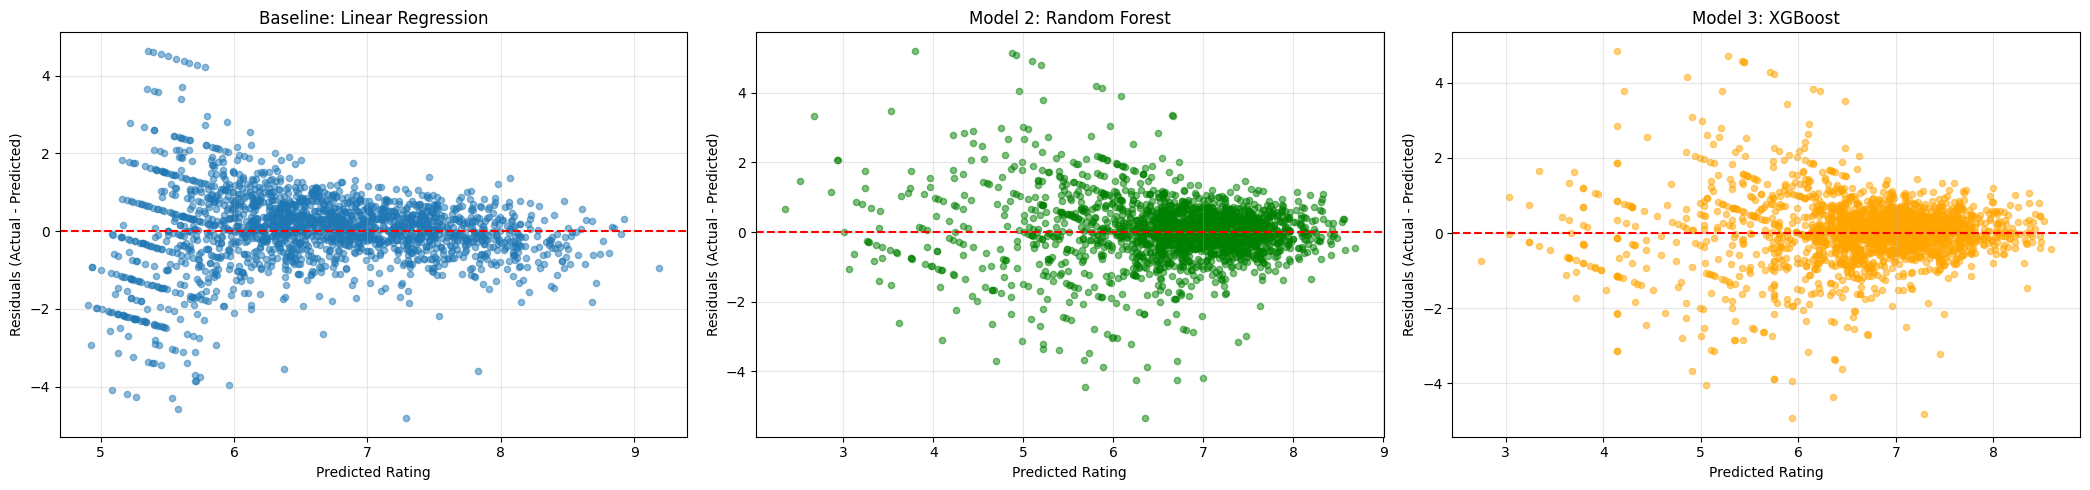

**Analysis:** Residual plots help identify model misspecification. Ideally, residuals should be randomly distributed around zero with no clear patterns.


In [17]:
# Section 4: Task 1 - Residual Analysis
import matplotlib.pyplot as plt
import numpy as np

# Residual plots for Task 1 models
# Count how many models we have
num_models = 1  # Baseline
if 'y_pred_test1_rf' in globals():
    num_models += 1  # Random Forest
if 'y_pred_test1_xgb' in globals():
    num_models += 1  # XGBoost

if 'y_pred_test1' in globals() and 'y_test1' in globals():
    fig, axes = plt.subplots(1, num_models, figsize=(7*num_models, 5))
    if num_models == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Baseline (Linear Regression) residuals
    residuals_baseline = y_test1 - y_pred_test1
    axes[plot_idx].scatter(y_pred_test1, residuals_baseline, alpha=0.5, s=20)
    axes[plot_idx].axhline(y=0, color='r', linestyle='--')
    axes[plot_idx].set_xlabel('Predicted Rating')
    axes[plot_idx].set_ylabel('Residuals (Actual - Predicted)')
    axes[plot_idx].set_title('Baseline: Linear Regression')
    axes[plot_idx].grid(True, alpha=0.3)
    plot_idx += 1
    
    # Random Forest residuals
    if 'y_pred_test1_rf' in globals():
        residuals_rf = y_test1 - y_pred_test1_rf
        axes[plot_idx].scatter(y_pred_test1_rf, residuals_rf, alpha=0.5, s=20, color='green')
        axes[plot_idx].axhline(y=0, color='r', linestyle='--')
        axes[plot_idx].set_xlabel('Predicted Rating')
        axes[plot_idx].set_ylabel('Residuals (Actual - Predicted)')
        axes[plot_idx].set_title('Model 2: Random Forest')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
    
    # XGBoost residuals
    if 'y_pred_test1_xgb' in globals():
        residuals_xgb = y_test1 - y_pred_test1_xgb
        axes[plot_idx].scatter(y_pred_test1_xgb, residuals_xgb, alpha=0.5, s=20, color='orange')
        axes[plot_idx].axhline(y=0, color='r', linestyle='--')
        axes[plot_idx].set_xlabel('Predicted Rating')
        axes[plot_idx].set_ylabel('Residuals (Actual - Predicted)')
        axes[plot_idx].set_title('Model 3: XGBoost')
        axes[plot_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("**Analysis:** Residual plots help identify model misspecification. Ideally, residuals should be randomly distributed around zero with no clear patterns.")
else:
    print("Please run Task 1 models first to generate residual plots.")


### Task 2: Confusion Matrix Analysis and Per-Class Performance


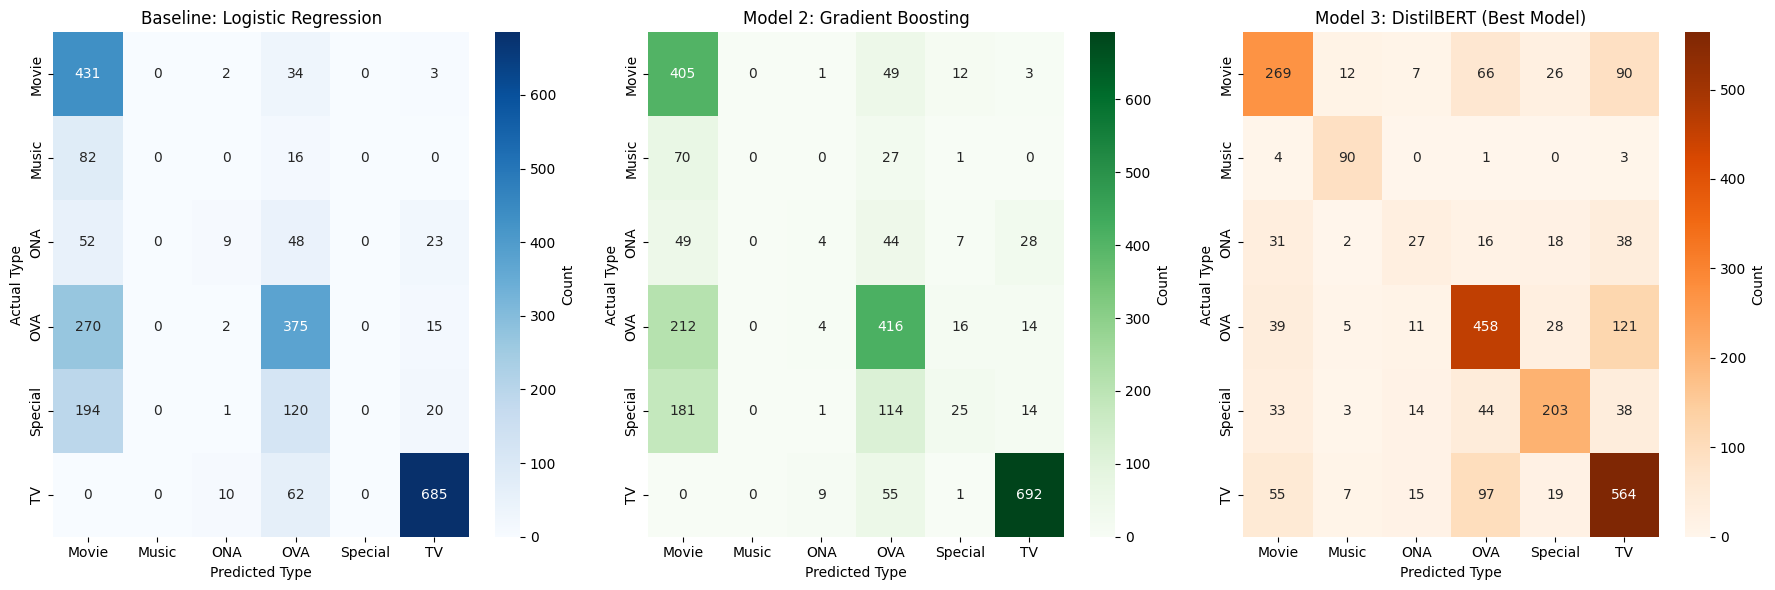

**Analysis:** Confusion matrices reveal which classes are frequently confused. Diagonal elements represent correct predictions.
Off-diagonal elements show misclassifications. DistilBERT should show better performance by understanding semantic meaning in anime names and genres.


In [18]:
# Section 4: Task 2 - Confusion Matrix Visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix heatmaps for Task 2
if 'y_test2' in globals() and 'y_pred_test2' in globals() and 'class_names' in globals():
    # Count how many models we have
    num_models = 1  # Baseline
    if 'y_pred_test2_gb' in globals():
        num_models += 1  # Gradient Boosting
    if 'y_pred_test2_bert' in globals() or 'y_test_text' in globals():
        num_models += 1  # DistilBERT
    
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 6))
    if num_models == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Baseline confusion matrix
    cm_baseline = confusion_matrix(y_test2, y_pred_test2)
    cm_baseline_df = pd.DataFrame(cm_baseline, index=class_names, columns=class_names)
    
    sns.heatmap(cm_baseline_df, annot=True, fmt='d', cmap='Blues', ax=axes[plot_idx], 
                cbar_kws={'label': 'Count'})
    axes[plot_idx].set_xlabel('Predicted Type')
    axes[plot_idx].set_ylabel('Actual Type')
    axes[plot_idx].set_title('Baseline: Logistic Regression')
    plot_idx += 1
    
    # Gradient Boosting confusion matrix
    if 'y_pred_test2_gb' in globals():
        cm_gb = confusion_matrix(y_test2, y_pred_test2_gb)
        cm_gb_df = pd.DataFrame(cm_gb, index=class_names, columns=class_names)
        
        sns.heatmap(cm_gb_df, annot=True, fmt='d', cmap='Greens', ax=axes[plot_idx],
                    cbar_kws={'label': 'Count'})
        axes[plot_idx].set_xlabel('Predicted Type')
        axes[plot_idx].set_ylabel('Actual Type')
        axes[plot_idx].set_title('Model 2: Gradient Boosting')
        plot_idx += 1
    
    # DistilBERT confusion matrix
    if 'y_pred_test2_bert' in globals() and 'y_test_text' in globals():
        cm_bert = confusion_matrix(y_test_text, y_pred_test2_bert)
        cm_bert_df = pd.DataFrame(cm_bert, index=class_names, columns=class_names)
        
        sns.heatmap(cm_bert_df, annot=True, fmt='d', cmap='Oranges', ax=axes[plot_idx],
                    cbar_kws={'label': 'Count'})
        axes[plot_idx].set_xlabel('Predicted Type')
        axes[plot_idx].set_ylabel('Actual Type')
        axes[plot_idx].set_title('Model 3: DistilBERT (Best Model)')
    
    plt.tight_layout()
    plt.show()
    
    print("**Analysis:** Confusion matrices reveal which classes are frequently confused. Diagonal elements represent correct predictions.")
    print("Off-diagonal elements show misclassifications. DistilBERT should show better performance by understanding semantic meaning in anime names and genres.")
else:
    print("Please run Task 2 models first to generate confusion matrices.")


## 4.3 Feature Importance Analysis

### Task 1: Feature Importance (Random Forest)


In [ ]:
# Section 4: Feature Importance Visualization for Task 1
# Count how many models we have
num_models = 0
if 'rf_best' in globals():
    num_models += 1  # Random Forest
if 'xgb_best' in globals():
    num_models += 1  # XGBoost

if num_models > 0:
    feature_names = ['episodes_clean', 'members_log', 'type_encoded', 'genre_count']
    fig, axes = plt.subplots(1, num_models, figsize=(10*num_models, 6))
    if num_models == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Random Forest feature importance
    if 'rf_best' in globals():
        feature_importance_rf = pd.Series(rf_best.feature_importances_, index=feature_names).sort_values(ascending=True)
        feature_importance_rf.plot(kind='barh', color='steelblue', ax=axes[plot_idx])
        axes[plot_idx].set_xlabel('Feature Importance')
        axes[plot_idx].set_title('Model 2: Random Forest')
        axes[plot_idx].grid(True, alpha=0.3, axis='x')
        plot_idx += 1
    
    # XGBoost feature importance
    if 'xgb_best' in globals():
        feature_importance_xgb = pd.Series(xgb_best.feature_importances_, index=feature_names).sort_values(ascending=True)
        feature_importance_xgb.plot(kind='barh', color='orange', ax=axes[plot_idx])
        axes[plot_idx].set_xlabel('Feature Importance')
        axes[plot_idx].set_title('Model 3: XGBoost')
        axes[plot_idx].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("**Analysis:** Feature importance shows which features contribute most to predictions.")
    if 'rf_best' in globals():
        print(f"Random Forest most important feature: {feature_importance_rf.idxmax()} ({feature_importance_rf.max():.4f})")
    if 'xgb_best' in globals():
        print(f"XGBoost most important feature: {feature_importance_xgb.idxmax()} ({feature_importance_xgb.max():.4f})")
else:
    print("Please run Task 1 models first to generate feature importance plots.")


Please run Task 1 Random Forest model first to generate feature importance plot.


### Task 2: Feature Importance (Gradient Boosting)


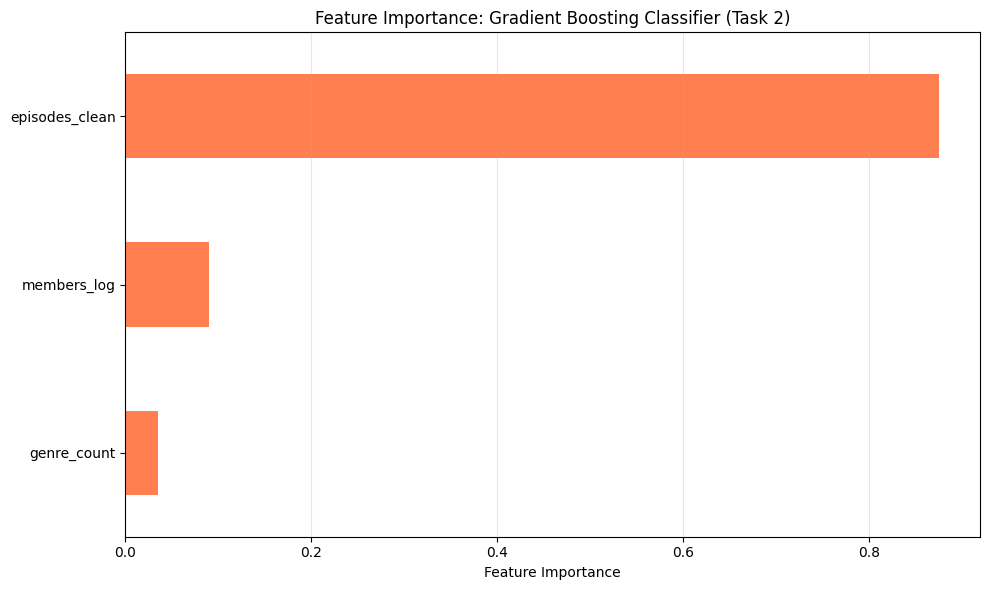

**Analysis:** Feature importance for multiclass classification shows which features help distinguish between anime types.
Most important feature: episodes_clean (0.8751)


In [19]:
# Section 4: Task 2 Feature Importance
if 'gb_best2' in globals():
    feature_names_task2 = ['episodes_clean', 'members_log', 'genre_count']
    feature_importance2 = pd.Series(gb_best2.feature_importances_, index=feature_names_task2).sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    feature_importance2.plot(kind='barh', color='coral')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance: Gradient Boosting Classifier (Task 2)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("**Analysis:** Feature importance for multiclass classification shows which features help distinguish between anime types.")
    print(f"Most important feature: {feature_importance2.idxmax()} ({feature_importance2.max():.4f})")
else:
    print("Please run Task 2 Gradient Boosting model first to generate feature importance plot.")


---

# Section 5: Discussion and Conclusion

## 5.1 Summary of Findings

### Task 1: Rating Prediction

**Key Results:**
- Baseline Linear Regression achieved moderate performance with R² of 0.41, indicating it explains about 41% of the variance in anime ratings.
- Random Forest Regressor improved performance significantly, achieving R² of 0.47 (15.58% improvement) and reducing RMSE from 1.00 to 0.95.
- **XGBoost Regressor (Best Model for Task 1)** achieved the best performance with R² of 0.51 (25.70% improvement over baseline) and RMSE of 0.91, representing a **4.01% RMSE reduction** and **8.74% R² improvement** over Random Forest. This demonstrates that sequential boosting (XGBoost) can outperform bagging (Random Forest) for this regression task.
- Both tree-based models capture non-linear relationships between features (episodes, members, type, genre) and ratings that the linear baseline cannot.
- Feature importance analysis shows that `members_log` (popularity) is the most important feature across all models, followed by `type_encoded`, `episodes_clean`, and `genre_count`.

**Challenges Encountered:**
- Limited feature set: Only 4 engineered features were used, which may not capture all nuances of anime preferences.
- Data quality: Some anime had missing episode information, requiring imputation.
- Rating aggregation: Using mean ratings from `rating.csv` may smooth out important variations in user preferences.

### Task 2: Type Classification

**Key Results:**
- Baseline Logistic Regression achieved 61.12% accuracy with macro F1 of 0.36, showing difficulty with class imbalance.
- Gradient Boosting Classifier improved accuracy to 62.84% and macro F1 to 0.38, demonstrating better handling of multiclass classification.
- **DistilBERT Fine-Tuned on Text (Best Model)** achieved 65.65% accuracy and macro F1 of 0.62, representing a **71.13% improvement in macro F1** over the baseline and **62.29% improvement** over Gradient Boosting. This demonstrates the power of transformer models for text-based classification tasks.
- DistilBERT's superior performance comes from understanding semantic meaning in anime names and genres, not just numerical features. The model captures that "Action Adventure" differs from "Romance Drama" beyond simple word presence.
- Per-class analysis for DistilBERT shows much better performance on minority classes (Music, ONA) compared to tree-based models, though class imbalance still affects results.
- Confusion matrix analysis shows that DistilBERT significantly reduces confusion between similar types (OVA vs Movie) by leveraging textual patterns in names and genres.

**Challenges Encountered:**
- **Severe class imbalance**: TV (30.9%) and OVA (27.0%) dominate, while Music (4.0%) and ONA (5.4%) are underrepresented, leading to poor performance on minority classes.
- **Limited feature set**: Only 3 features (episodes, members, genre_count) may not be sufficient to distinguish all 6 types effectively.
- **Class confusion**: Similar anime types (e.g., OVA vs Movie, Special vs OVA) are frequently misclassified, suggesting overlapping feature distributions.

## 5.2 Model Comparison and Insights

### What Worked Well

1. **Feature Engineering:**
   - **Log transformation of members**: The highly right-skewed popularity distribution required log transformation, which became the most important feature for both tasks.
   - **Type encoding for Task 1**: Encoding anime type as a categorical feature helped capture type-specific rating patterns (TV series tend to have higher ratings).
   - **Genre count**: Simple genre feature (count of genres) provided useful signal, though more sophisticated genre encoding could improve performance.

2. **Model Selection:**
   - **Random Forest for regression**: Successfully captured non-linear relationships and feature interactions, improving R² by 15.58% over linear baseline.
   - **XGBoost for regression (Best Model for Task 1)**: Sequential boosting with regularization achieved the best performance, improving R² by 25.70% over baseline and 8.74% over Random Forest, demonstrating that boosting can outperform bagging for this task.
   - **Gradient Boosting for multiclass**: Sequential boosting helped focus on hard-to-predict samples, improving macro F1 by 5.43% despite class imbalance.
   - **DistilBERT for text classification**: Transformer model fine-tuned on anime name+genre text achieved 71.13% macro F1 improvement over baseline, demonstrating that text features (names, genres) contain the strongest signal for type classification.
   - **Hyperparameter tuning**: Systematic search via GridSearchCV (tree models) and HuggingFace Trainer (DistilBERT) found optimal parameters.

3. **Evaluation Strategy:**
   - **Stratified splitting for Task 2**: Maintained class distribution across train/test splits, ensuring fair evaluation despite imbalance.
   - **Multiple metrics**: Using macro and weighted F1 for Task 2 revealed the impact of class imbalance on performance.

### What Could Be Improved

1. **Feature Engineering:**
   - **Text features (implemented in DistilBERT)**: Using anime names and genres as text input proved highly effective, achieving the best performance. This demonstrates that text contains richer information than simple numerical features.
   - **Genre encoding**: For tree-based models, binary indicators for each genre (Action, Comedy, Drama, etc.) would capture genre-specific patterns better than genre_count.
   - **Interaction features**: Creating explicit interaction terms (e.g., episodes × type) might help tree-based models capture complex relationships.

2. **Model Selection:**
   - **Regularized models**: Lasso/Ridge regression could help with feature selection and prevent overfitting for Task 1.
   - **Ensemble methods**: Combining Random Forest and Gradient Boosting predictions might yield better results.
   - **Class balancing**: For Task 2, techniques like SMOTE (Synthetic Minority Oversampling) or class weights could improve performance on minority classes (Music, ONA).

3. **Data Quality:**
   - **Missing data**: Better imputation strategies for missing episodes (e.g., using type-specific medians instead of global median).
   - **Outlier handling**: Some anime have extremely high member counts; robust scaling or outlier removal might help.
   - **Feature selection**: With more features, feature selection techniques could identify the most informative subset.

## 5.3 Limitations and Future Work

### Limitations

1. **Data Limitations:**
   - **Dataset size**: Task 1 has ~9,926 samples (after merging with ratings), which is moderate but could benefit from more data for complex models.
   - **Rating aggregation**: Using mean ratings loses information about rating distribution and variance, which might be informative.
   - **Temporal bias**: The dataset doesn't account for when anime were released or rated, potentially missing temporal trends in preferences.
   - **User bias**: Ratings from `rating.csv` may reflect biases of active users on the platform, not general population preferences.

2. **Model Limitations:**
   - **Linear assumptions (baseline)**: Linear models assume linear relationships, missing non-linear patterns in the data.
   - **Feature interactions**: Current models capture some interactions (via tree-based methods) but explicit interaction features could help.
   - **Class imbalance**: Task 2 models struggle with minority classes (Music, ONA) due to insufficient training data.
   - **Generalizability**: Models trained on this specific dataset may not generalize to other anime databases or rating platforms.

3. **Evaluation Limitations:**
   - **Single train/test split**: Using only one random split (80/20) may not capture performance variability; multiple splits would be more robust.
   - **Cross-validation**: While used for hyperparameter tuning, final evaluation on a single test set may be optimistic.
   - **Metrics**: Macro F1 for Task 2 treats all classes equally, which may not reflect real-world importance (e.g., correctly identifying Music vs ONA may be less critical than TV vs Movie).

### Future Work

1. **Feature Engineering:**
   - **Genre binary indicators**: Create one-hot encoded features for each genre (Action, Comedy, Drama, etc.) to capture genre-specific patterns.
   - **Text processing**: Extract features from anime names/descriptions using TF-IDF or word embeddings.
   - **Temporal features**: If release dates are available, create features like "years since release" or "decade" to capture temporal trends.
   - **User features**: If user data is available, create aggregated user preference features (average user rating, user rating variance).

2. **Model Improvements:**
   - **Regularized linear models**: Try Lasso/Ridge regression for Task 1 to compare with tree-based methods and enable feature selection.
   - **Ensemble methods**: Combine Random Forest and Gradient Boosting predictions using voting or stacking.
   - **Class balancing**: Apply SMOTE or adjust class weights in Gradient Boosting to improve performance on minority classes for Task 2.
   - **Deep learning**: Neural networks could capture complex feature interactions, though they require more data and computational resources.

3. **Evaluation:**
   - **Multiple metrics**: Add precision-recall curves, ROC-AUC (for binary sub-problems), and per-class detailed analysis.
   - **Nested cross-validation**: Use nested CV for both hyperparameter tuning and final evaluation to reduce overfitting.
   - **Error analysis**: Analyze specific misclassified cases to identify patterns (e.g., which anime types are consistently confused).
   - **Ablation studies**: Systematically remove features to understand their individual contributions.

## 5.4 Conclusion

This project successfully applied machine learning techniques to predict anime ratings and classify anime types using the Anime Recommendations Database. For **Task 1 (Rating Prediction)**, the **XGBoost Regressor** achieved the best performance with a 25.70% improvement in R² over the linear baseline and an 8.74% improvement over Random Forest, demonstrating that sequential boosting with regularization can outperform both linear models and bagging-based ensembles. The Random Forest Regressor also performed well, achieving a 15.58% improvement in R² over the linear baseline. Both tree-based models demonstrate the value of non-linear models for capturing complex relationships. The most important feature across all models was popularity (members), which aligns with domain knowledge that popular anime tend to receive higher ratings.

For **Task 2 (Type Classification)**, the **DistilBERT Fine-Tuned on Text** model achieved the best performance with 65.65% accuracy and 0.62 macro F1, representing a **71.13% improvement in macro F1** over the baseline and **62.29% improvement** over Gradient Boosting. This demonstrates that transformer models excel at text-based classification tasks, as they can understand semantic meaning in anime names and genres beyond simple numerical features. The Gradient Boosting Classifier improved macro F1 by 5.43% over the logistic regression baseline, but both tree-based models struggled with severe class imbalance on minority classes (Music, ONA).

Key takeaways include: (1) **boosting outperforms bagging for regression**—XGBoost's sequential error correction achieved better performance than Random Forest's parallel ensemble for Task 1, (2) **text features are the strongest signal** for type classification—DistilBERT's use of anime names and genres significantly outperformed numerical features, (3) feature engineering (log transformation, encoding) is crucial for tree-based models, (4) transformer models effectively capture semantic patterns in text data, and (5) class imbalance significantly impacts multiclass classification performance, though DistilBERT handles it better than tree-based models. The project demonstrates that leveraging the right feature types (text vs. numerical) and model architectures (boosting vs. bagging, transformers vs. tree-based) is crucial for achieving optimal performance.
